# Figs of WMT tendency terms
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Annual-mean global fig of each term](#first-bullet)
* [Monthly Climatology](#third-bullet)

> Note: the time dimension is for entire 40-yr run of CESM data

In [64]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [65]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.9b909521bdac43169f438399c8f0e44e/status,


In [63]:
cluster.close()
client.close()

In [2]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
from xhistogram.xarray import histogram

In [14]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(path):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/'+
                                              path +'_histograms.zarr'))
    return ds
    
natl = xr.merge([open_ds('natl'), open_ds('surf_natl')])
satl = xr.merge([open_ds('satl'), open_ds('surf_satl')])
npac = xr.merge([open_ds('npac'), open_ds('surf_npac')])
spac = xr.merge([open_ds('spac'), open_ds('surf_spac')])
ind = xr.merge([open_ds('ind'), open_ds('surf_ind')])
arc = xr.merge([open_ds('arc'), open_ds('surf_arc')])
south = xr.merge([open_ds('south'), open_ds('surf_south')])

global_hist = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/histograms.zarr'))

# 1) Annual-mean global fig <a class='anchor' id='first-bullet'> </a>
(use logarithmic scale on y-axis)

In [4]:
def ann_mean1(ds):
    (ds/1e6).mean('time').to_array().plot(col='variable', col_wrap=2, figsize=(20, 12));

In [19]:
def ann_mean2(ds):
    fig = plt.figure(figsize=(12,5))
    line_colors=['blue', 'k', 'orange', 'green', 'purple', 'yellow'] #order of cab, rho, sss, sst, surf heat, surf salt
    for (i,j) in zip(list(ds.data_vars), line_colors):
        (ds[i].mean('time')/1e6).plot(label=f'{i}', color=j)
    plt.legend()
    plt.ylabel(r'Transformation (Sv)', fontsize=16)
    plt.grid()
    plt.title('Annual Mean Transformation Terms', fontsize=20);

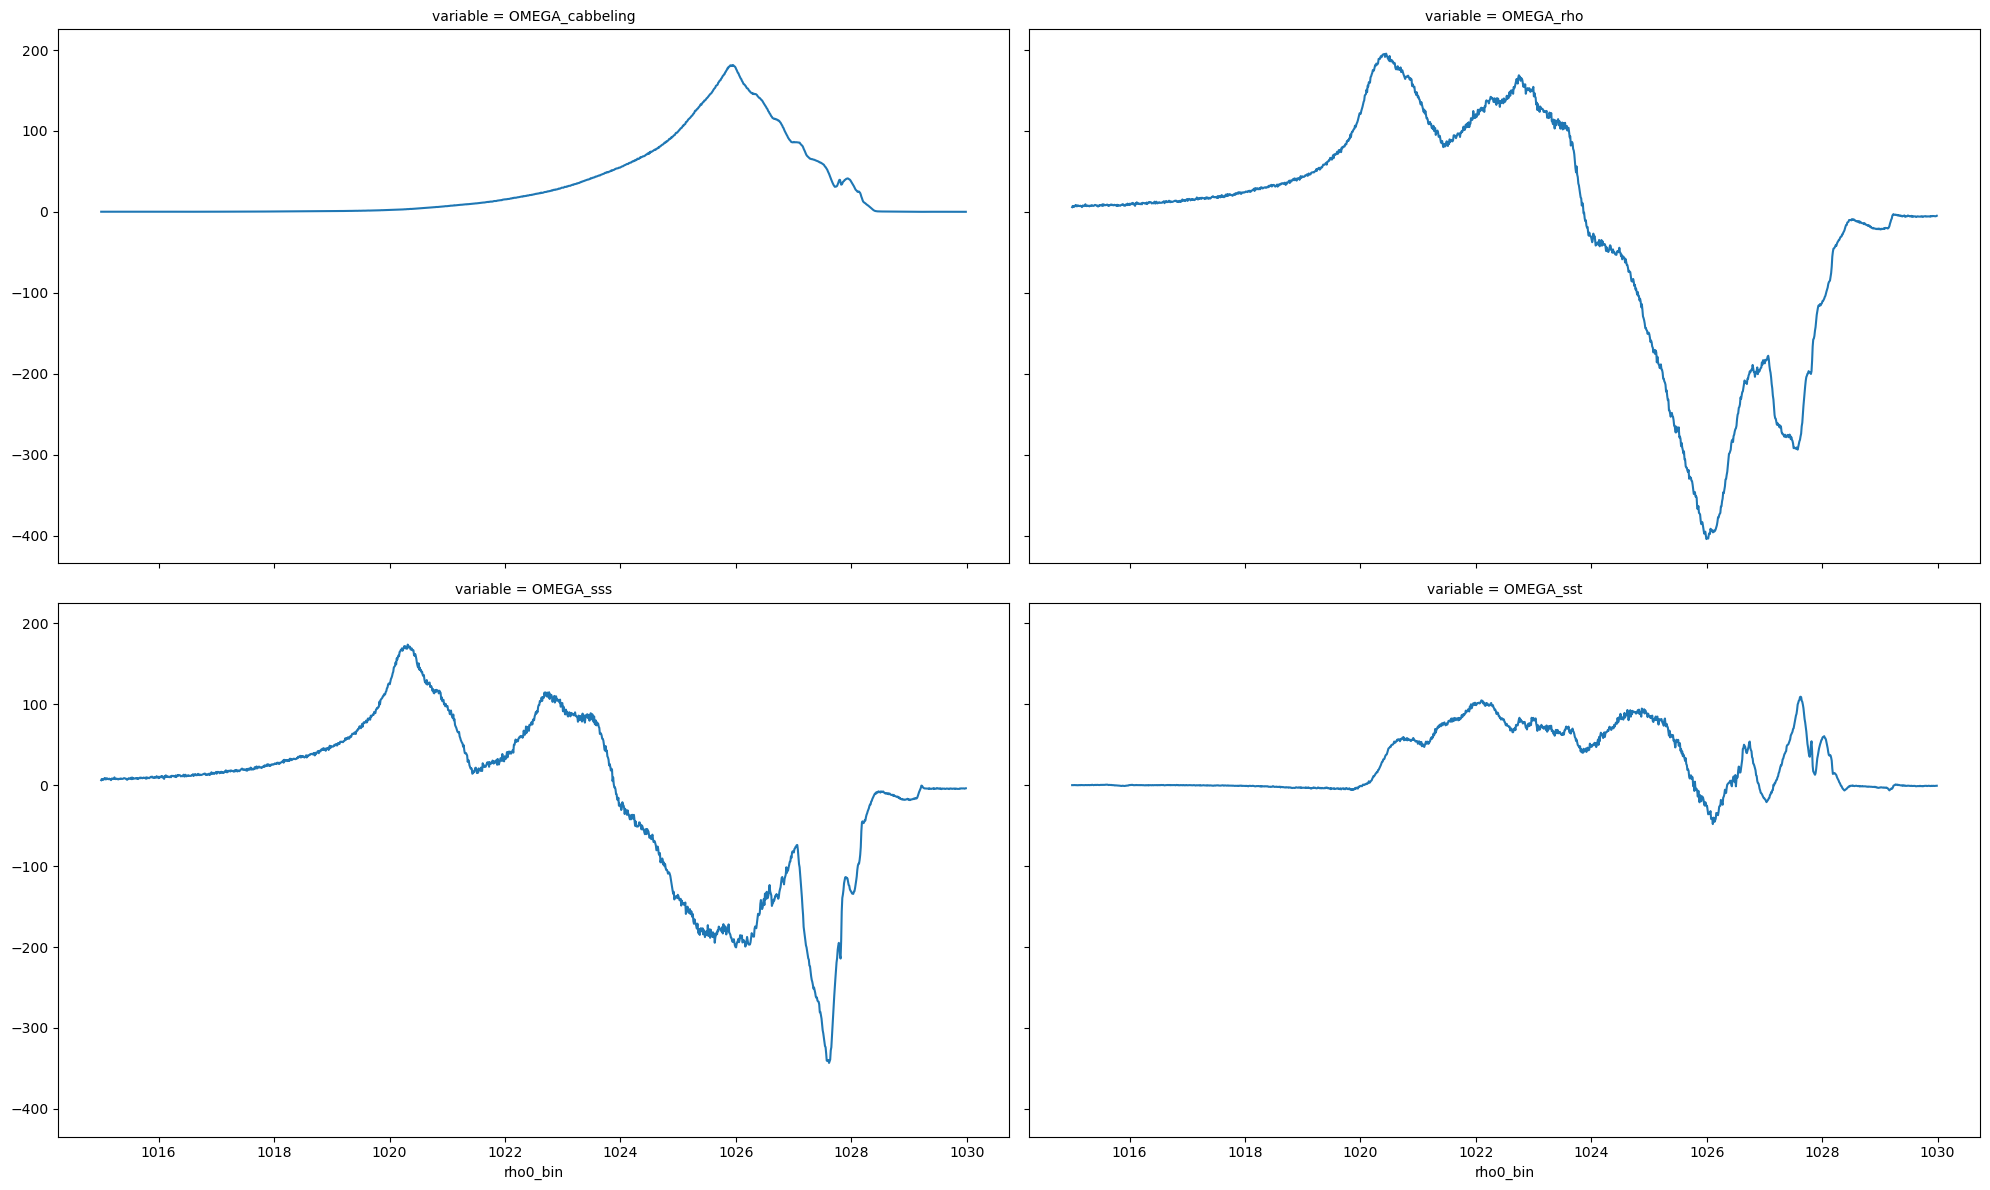

In [8]:
ann_mean1(global_hist)

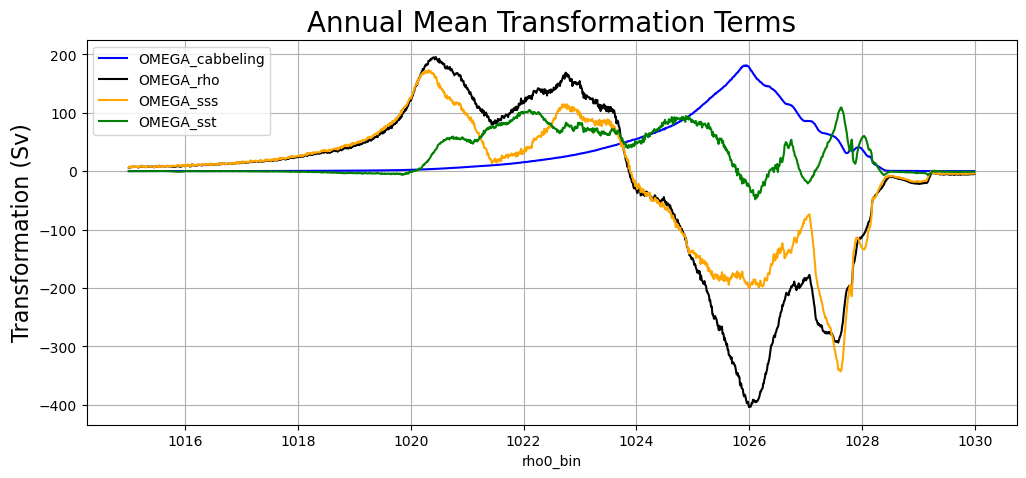

In [38]:
ann_mean2(global_hist)

## 1a) Annual-mean North ATL fig

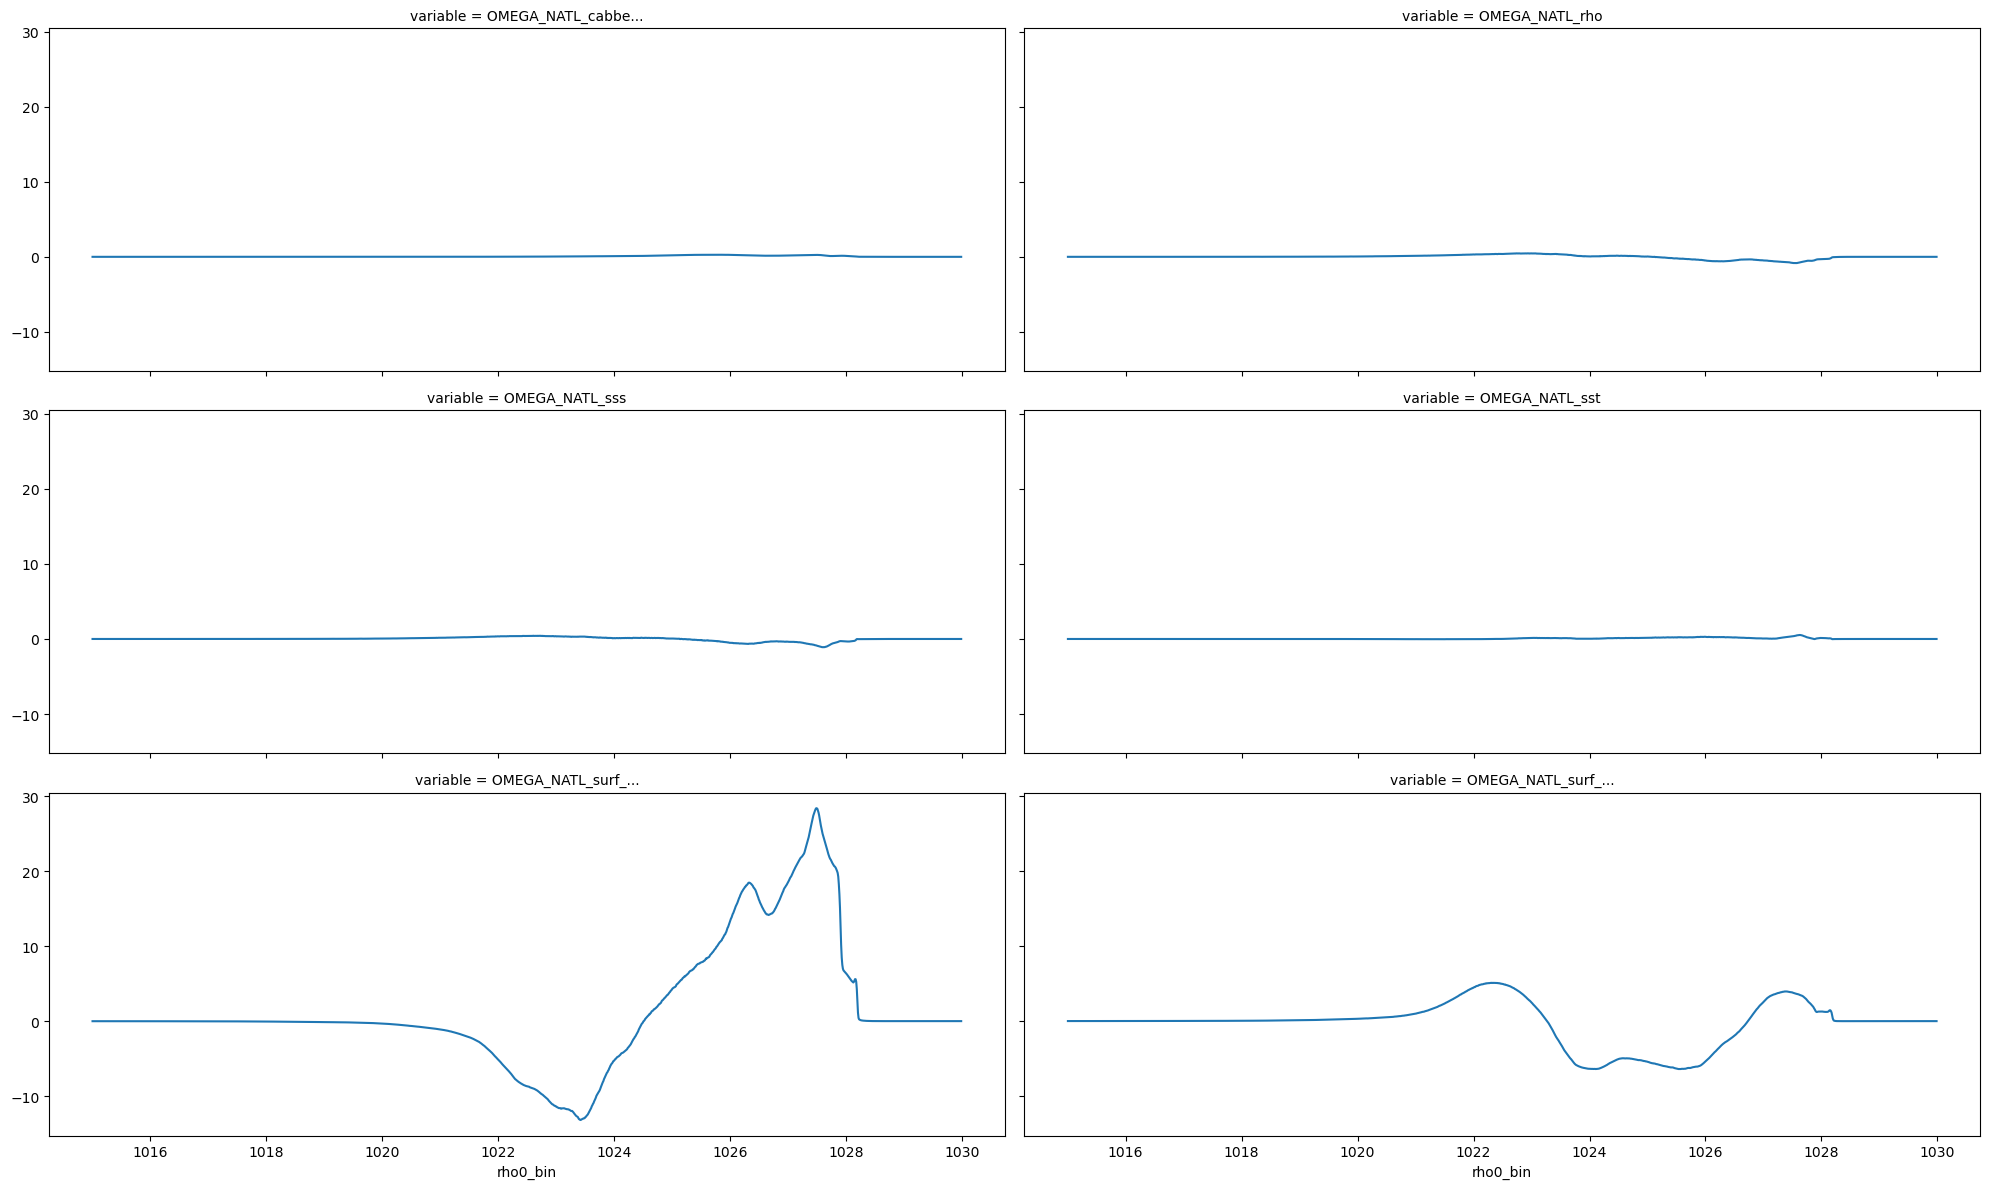

In [20]:
ann_mean1(natl)

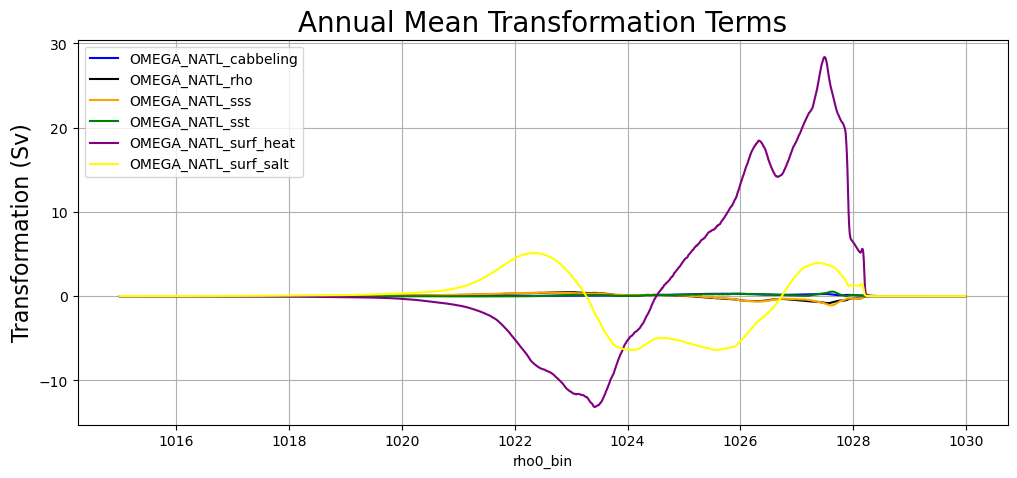

In [21]:
ann_mean2(natl)

## 1b) Annual-mean South ATL fig

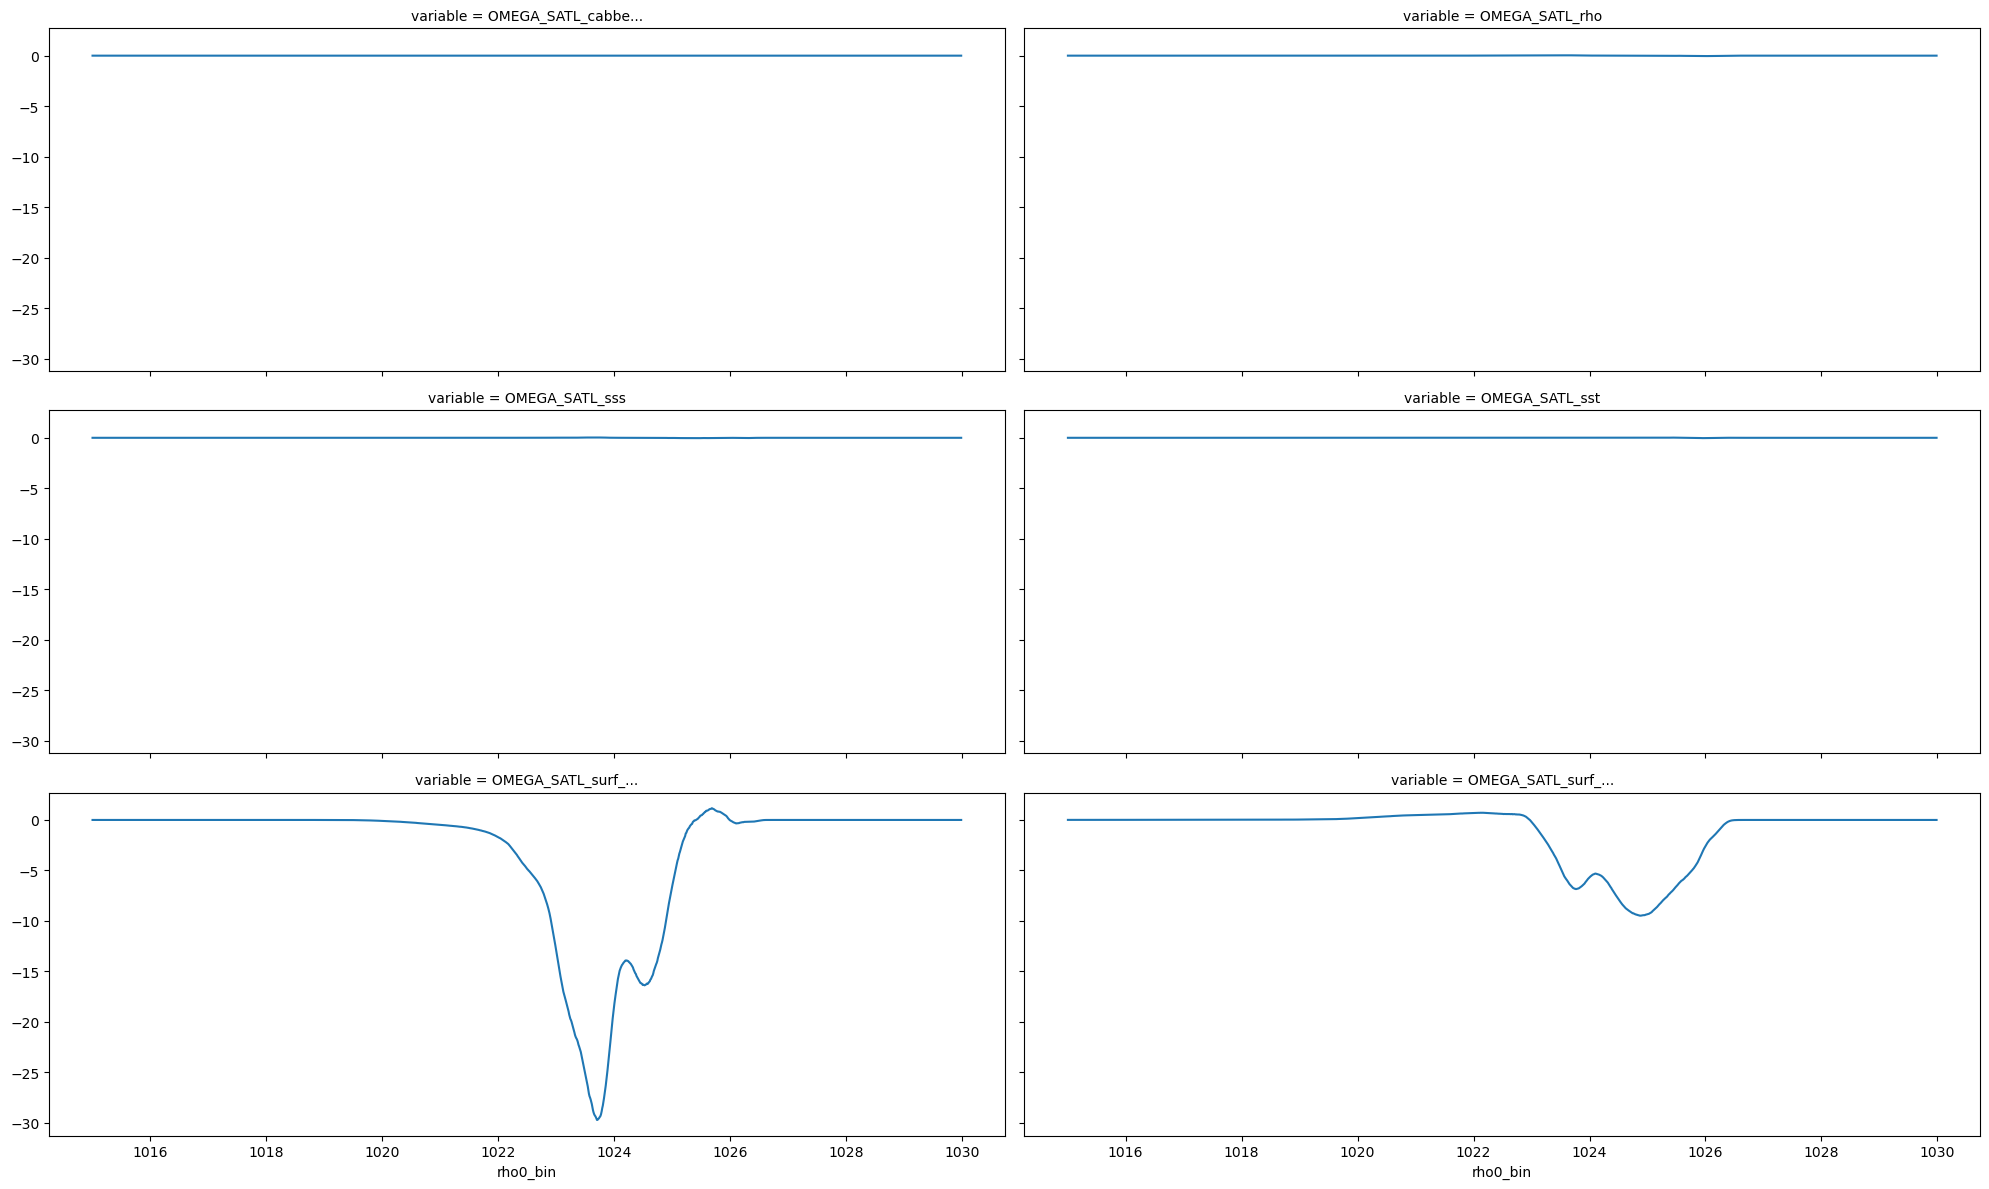

In [22]:
ann_mean1(satl)

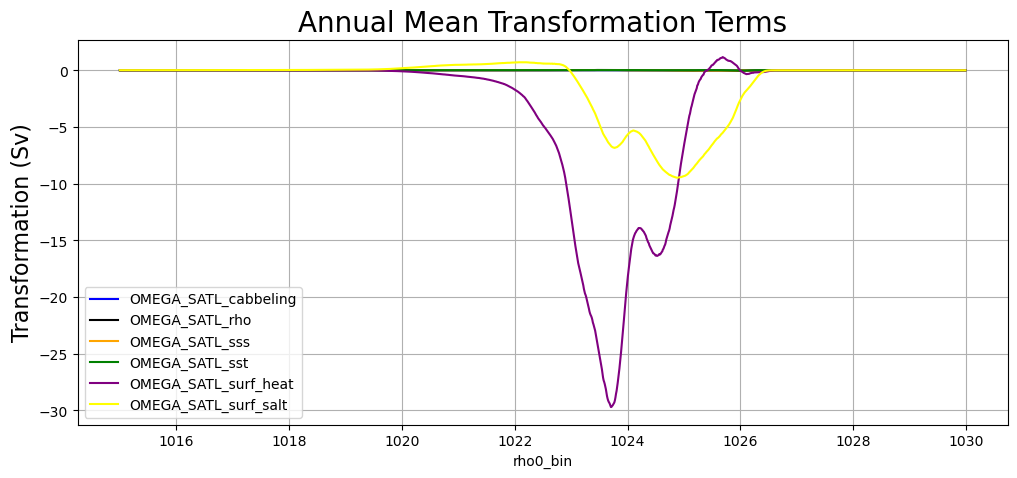

In [23]:
ann_mean2(satl)

## 1c) Annual-mean North PAC fig

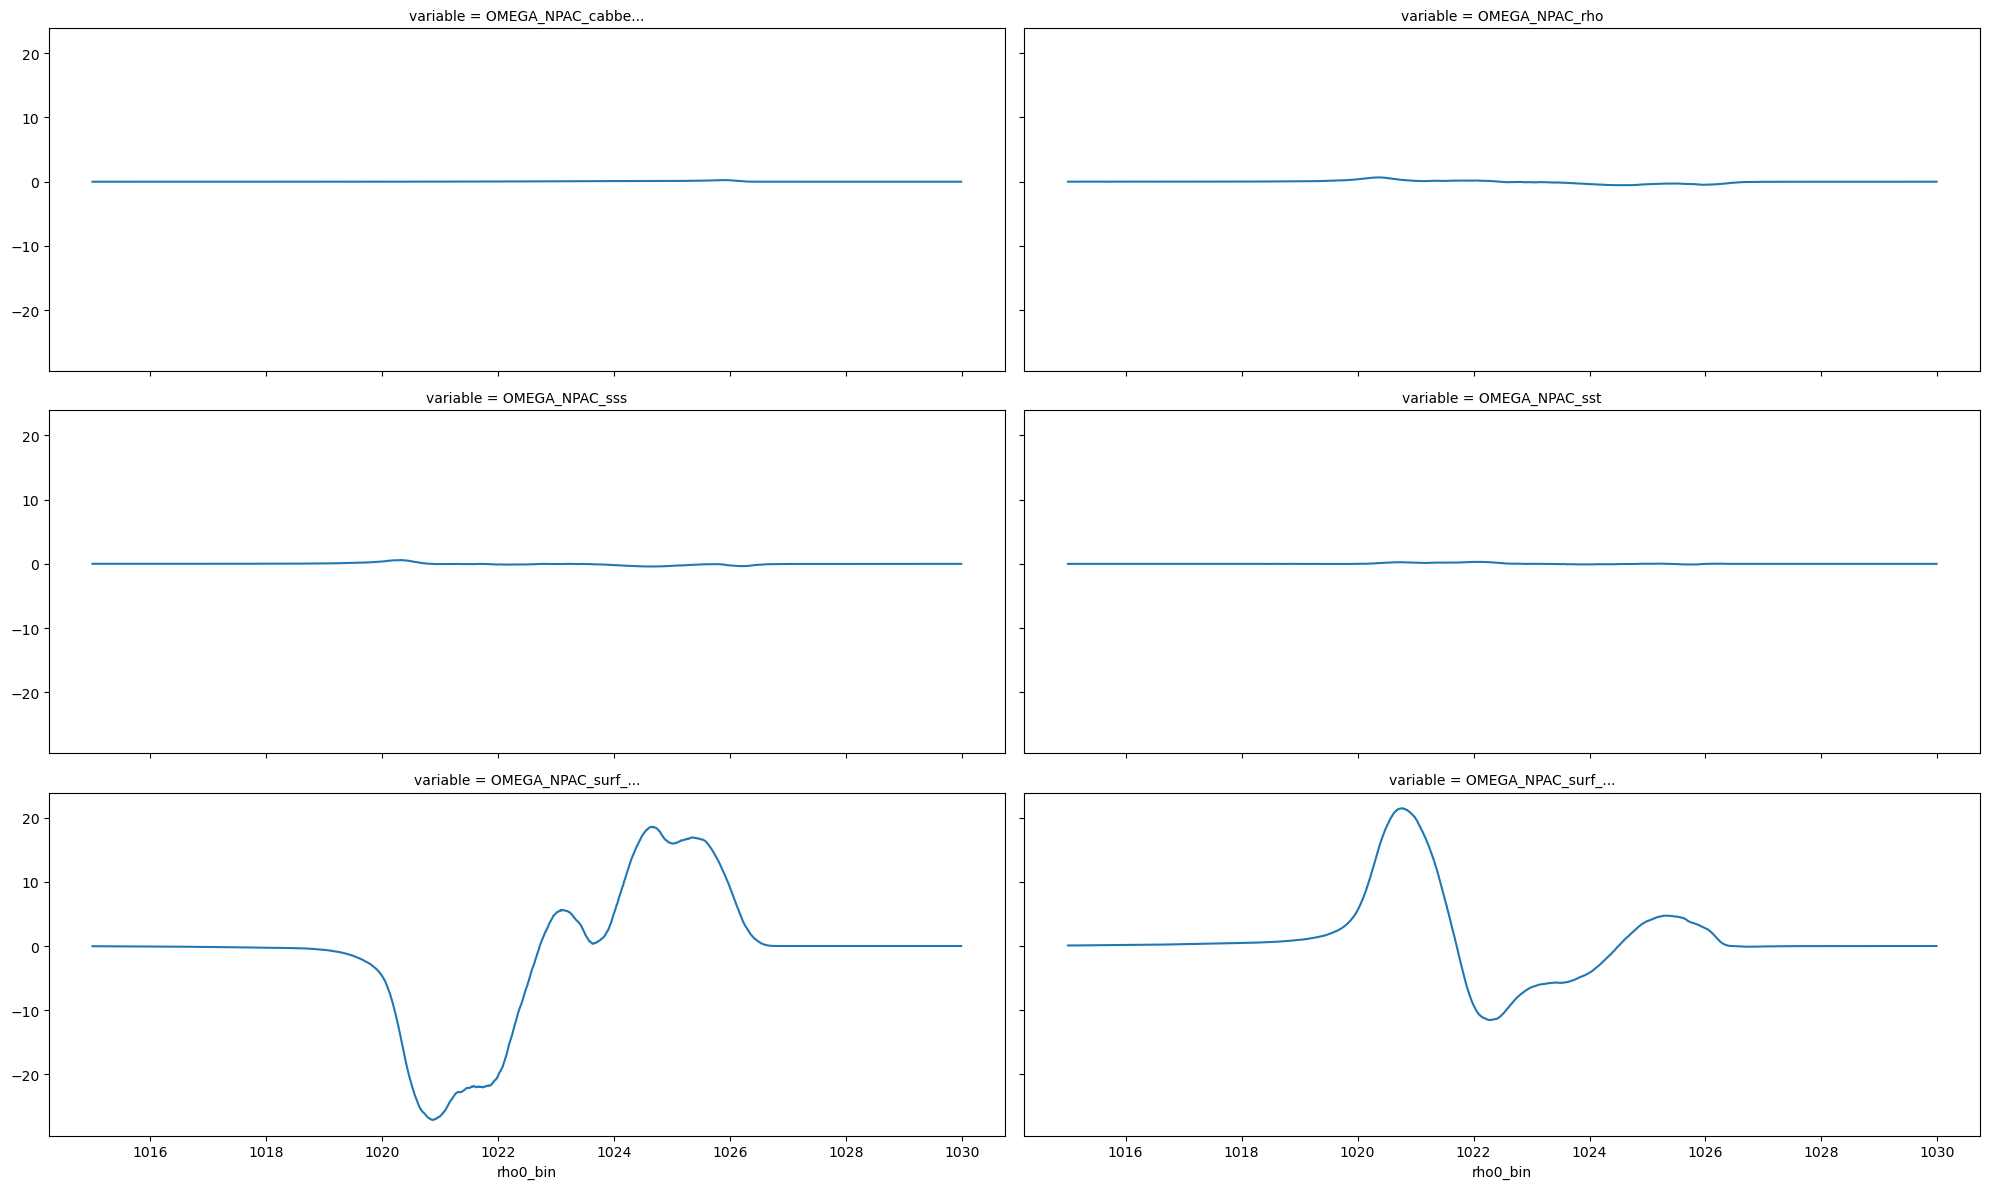

In [24]:
ann_mean1(npac)

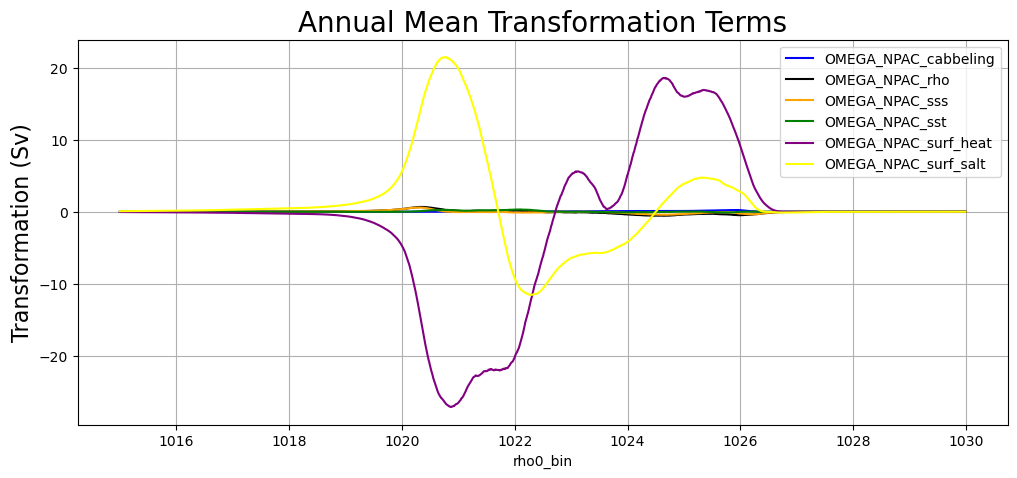

In [25]:
ann_mean2(npac)

## 1d) Annual-mean South PAC fig

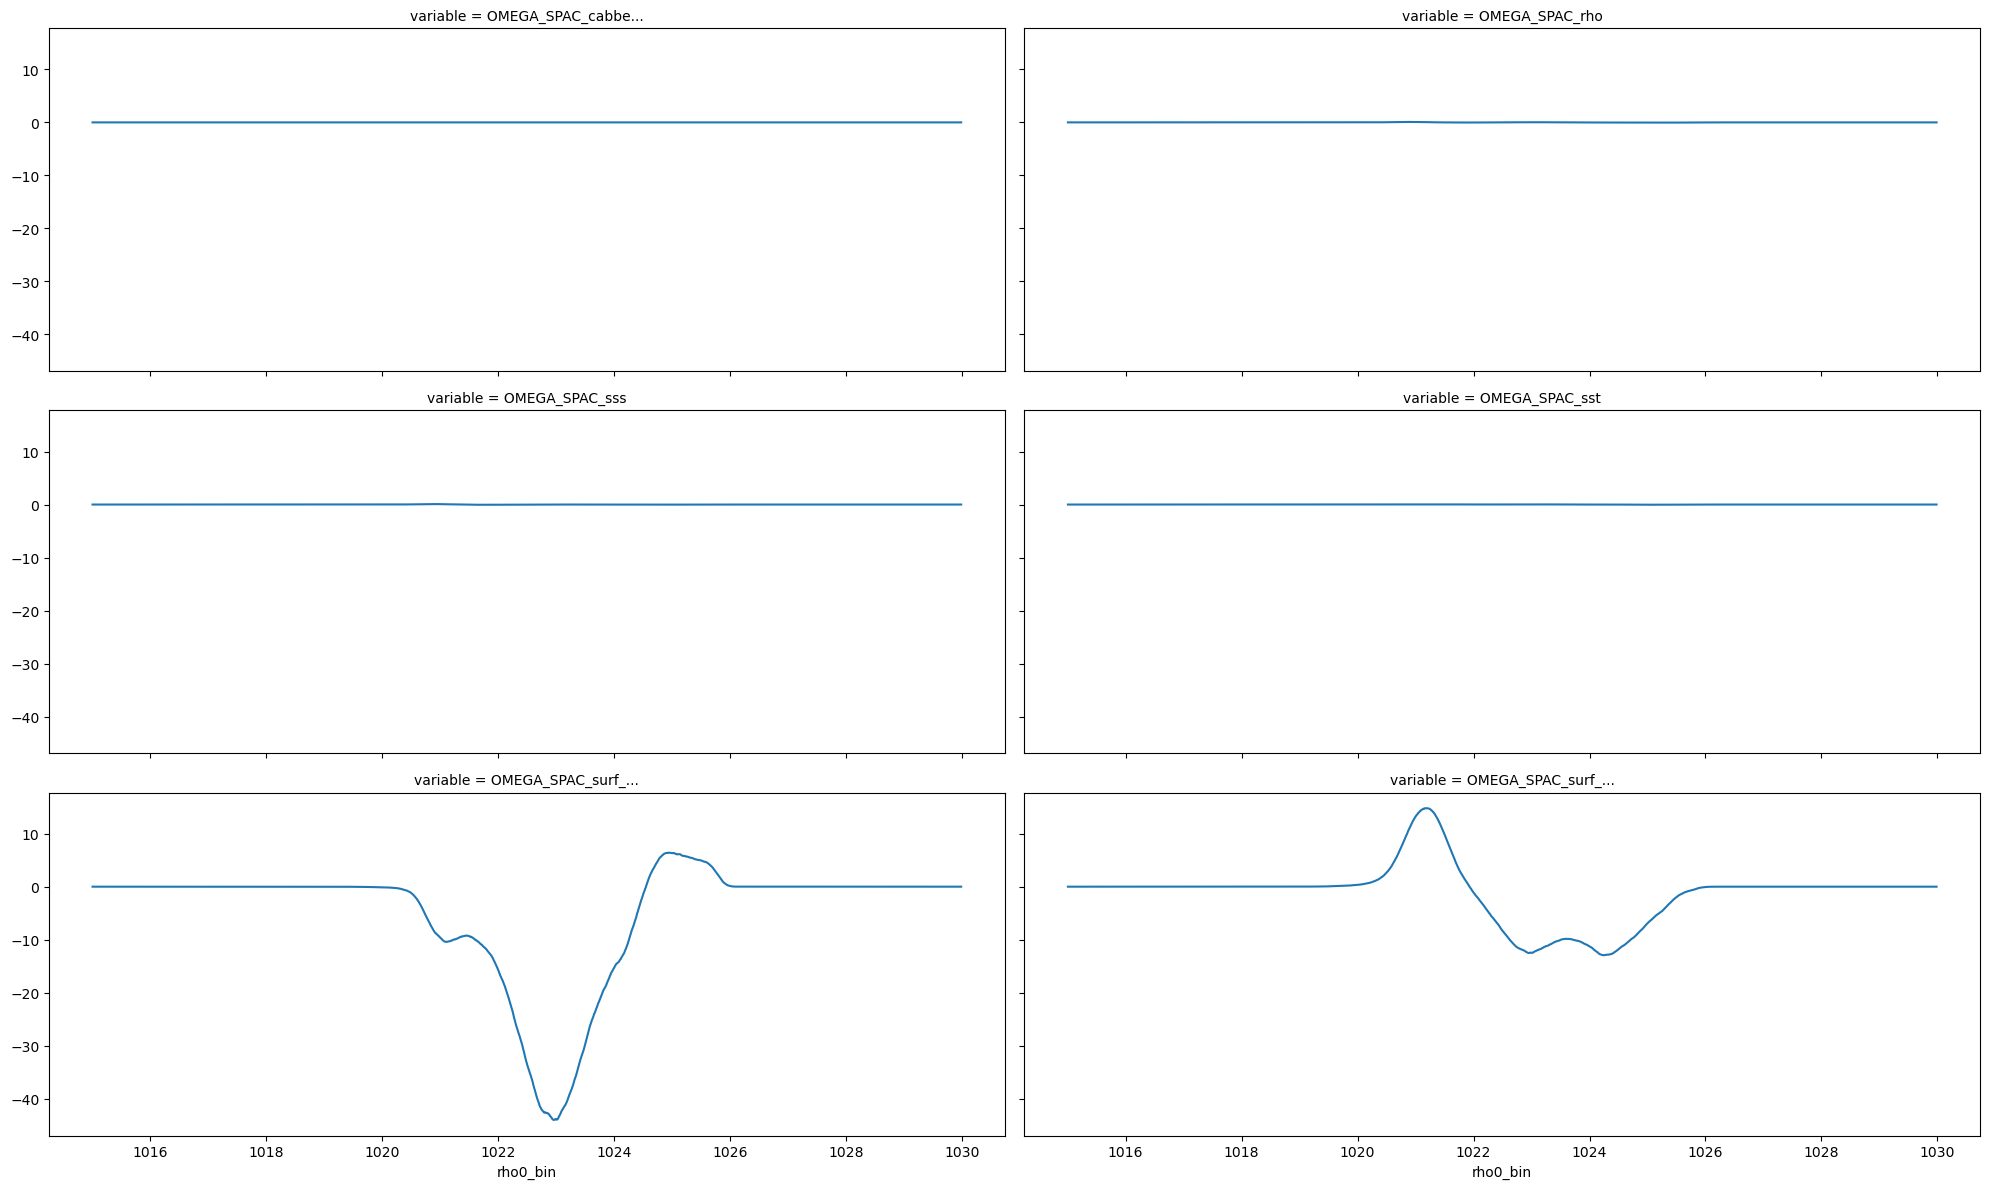

In [26]:
ann_mean1(spac)

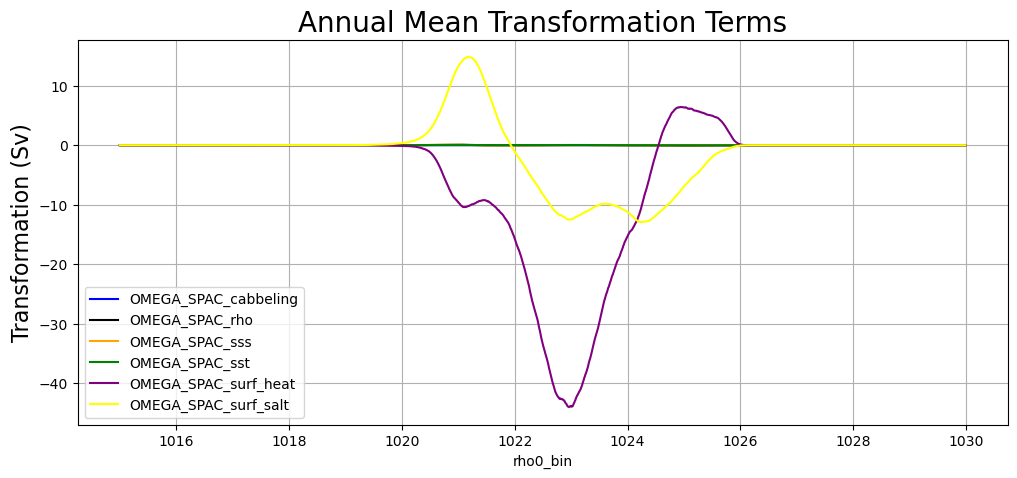

In [27]:
ann_mean2(spac)

## 1e) Annual-mean IND fig

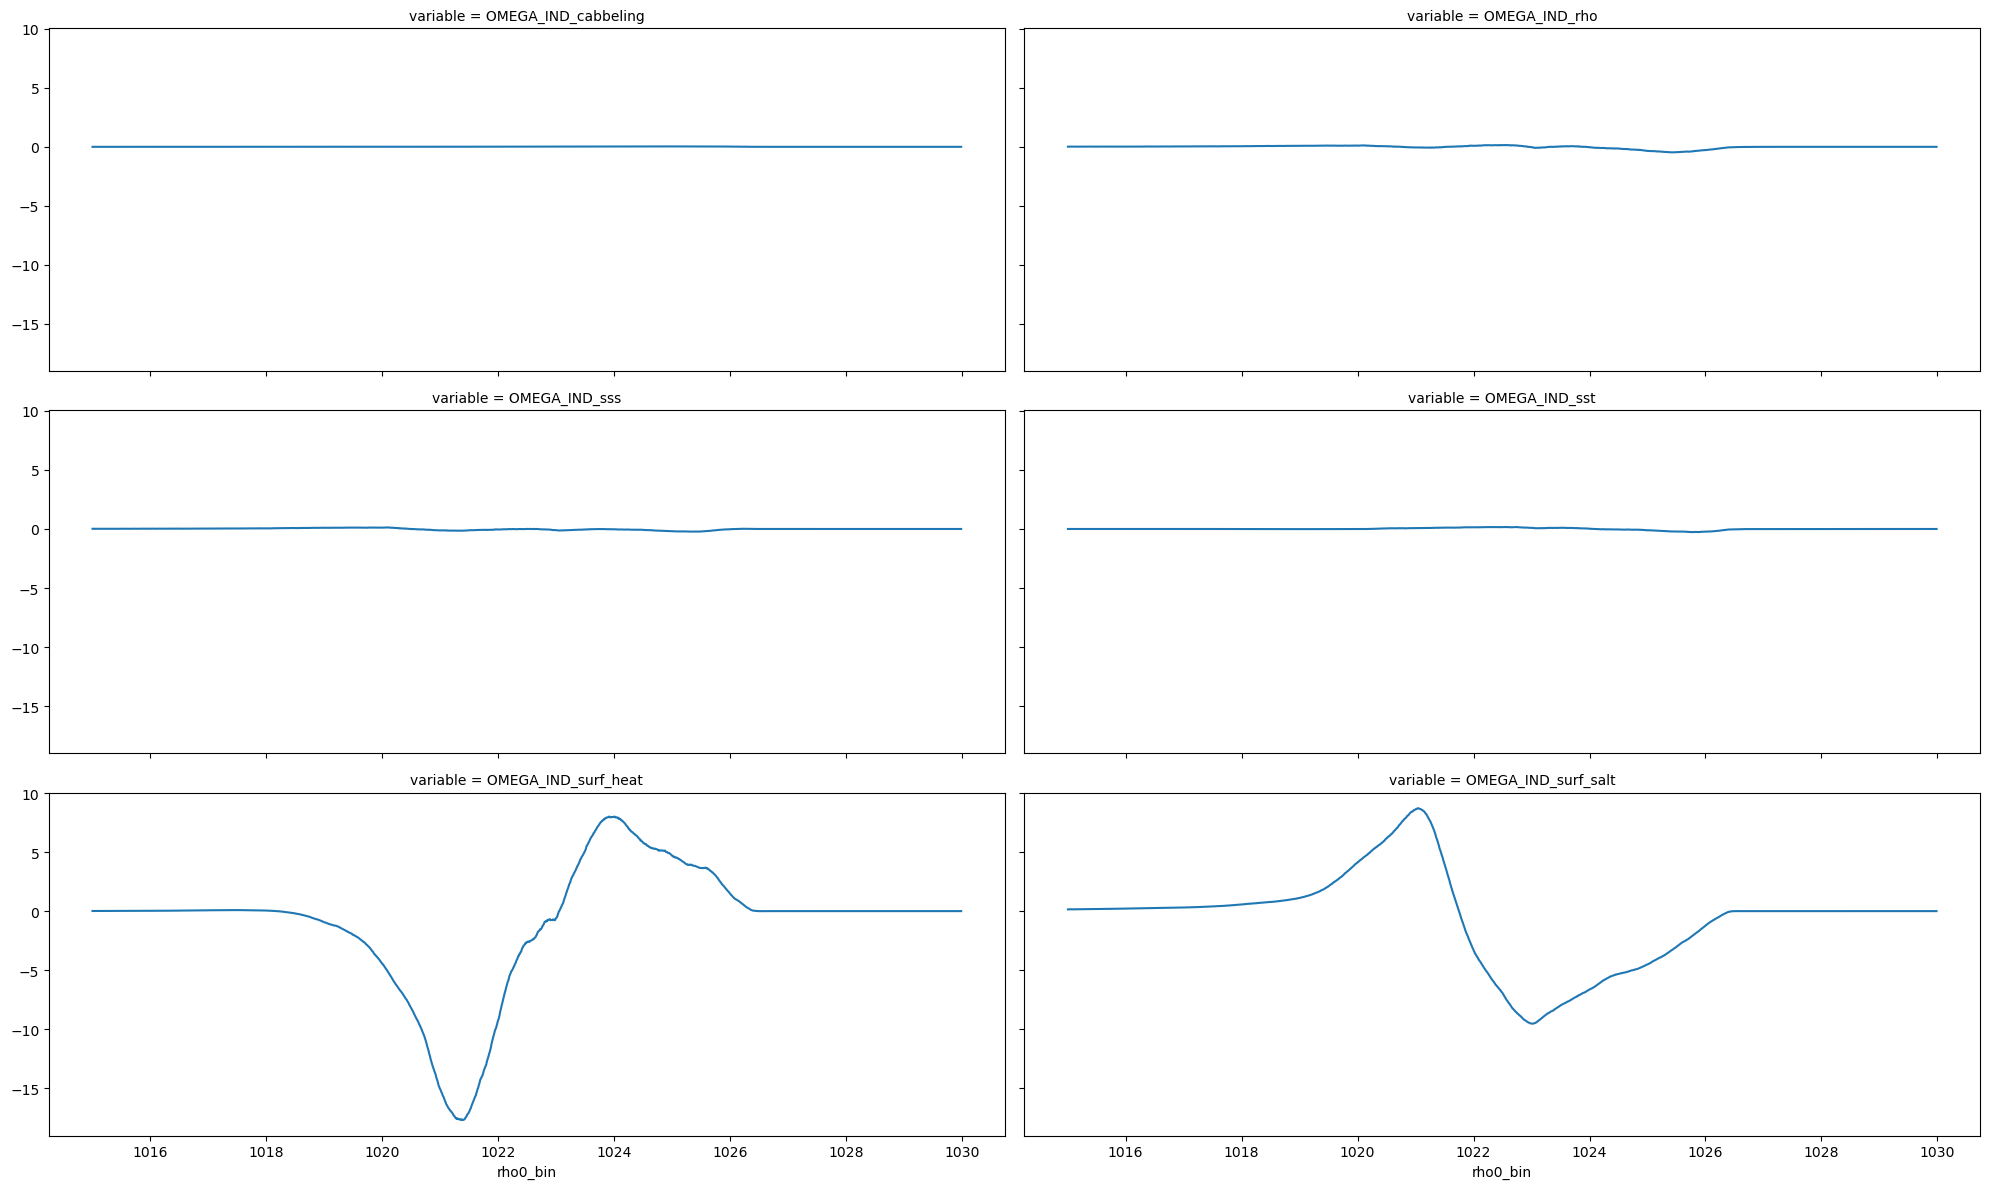

In [34]:
ann_mean1(ind)

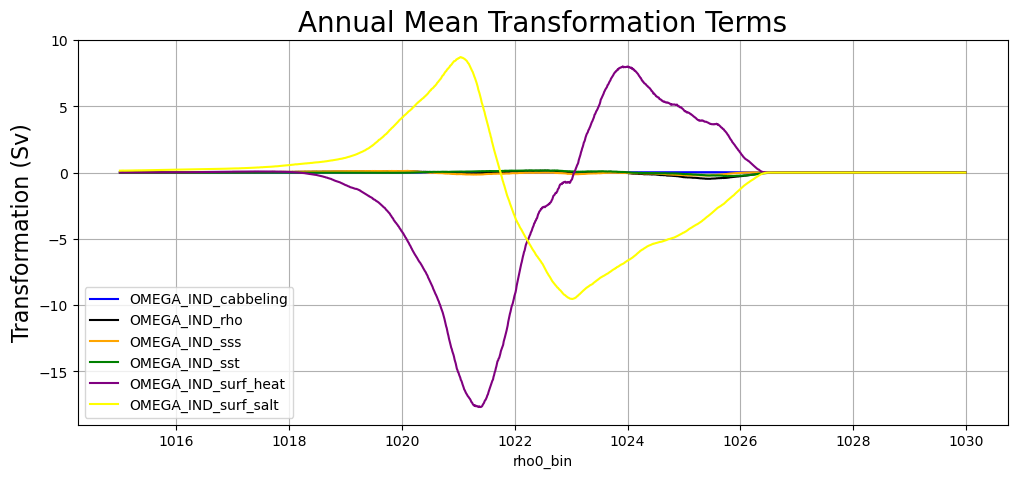

In [35]:
ann_mean2(ind)

## 1f) Annual-mean ARC fig

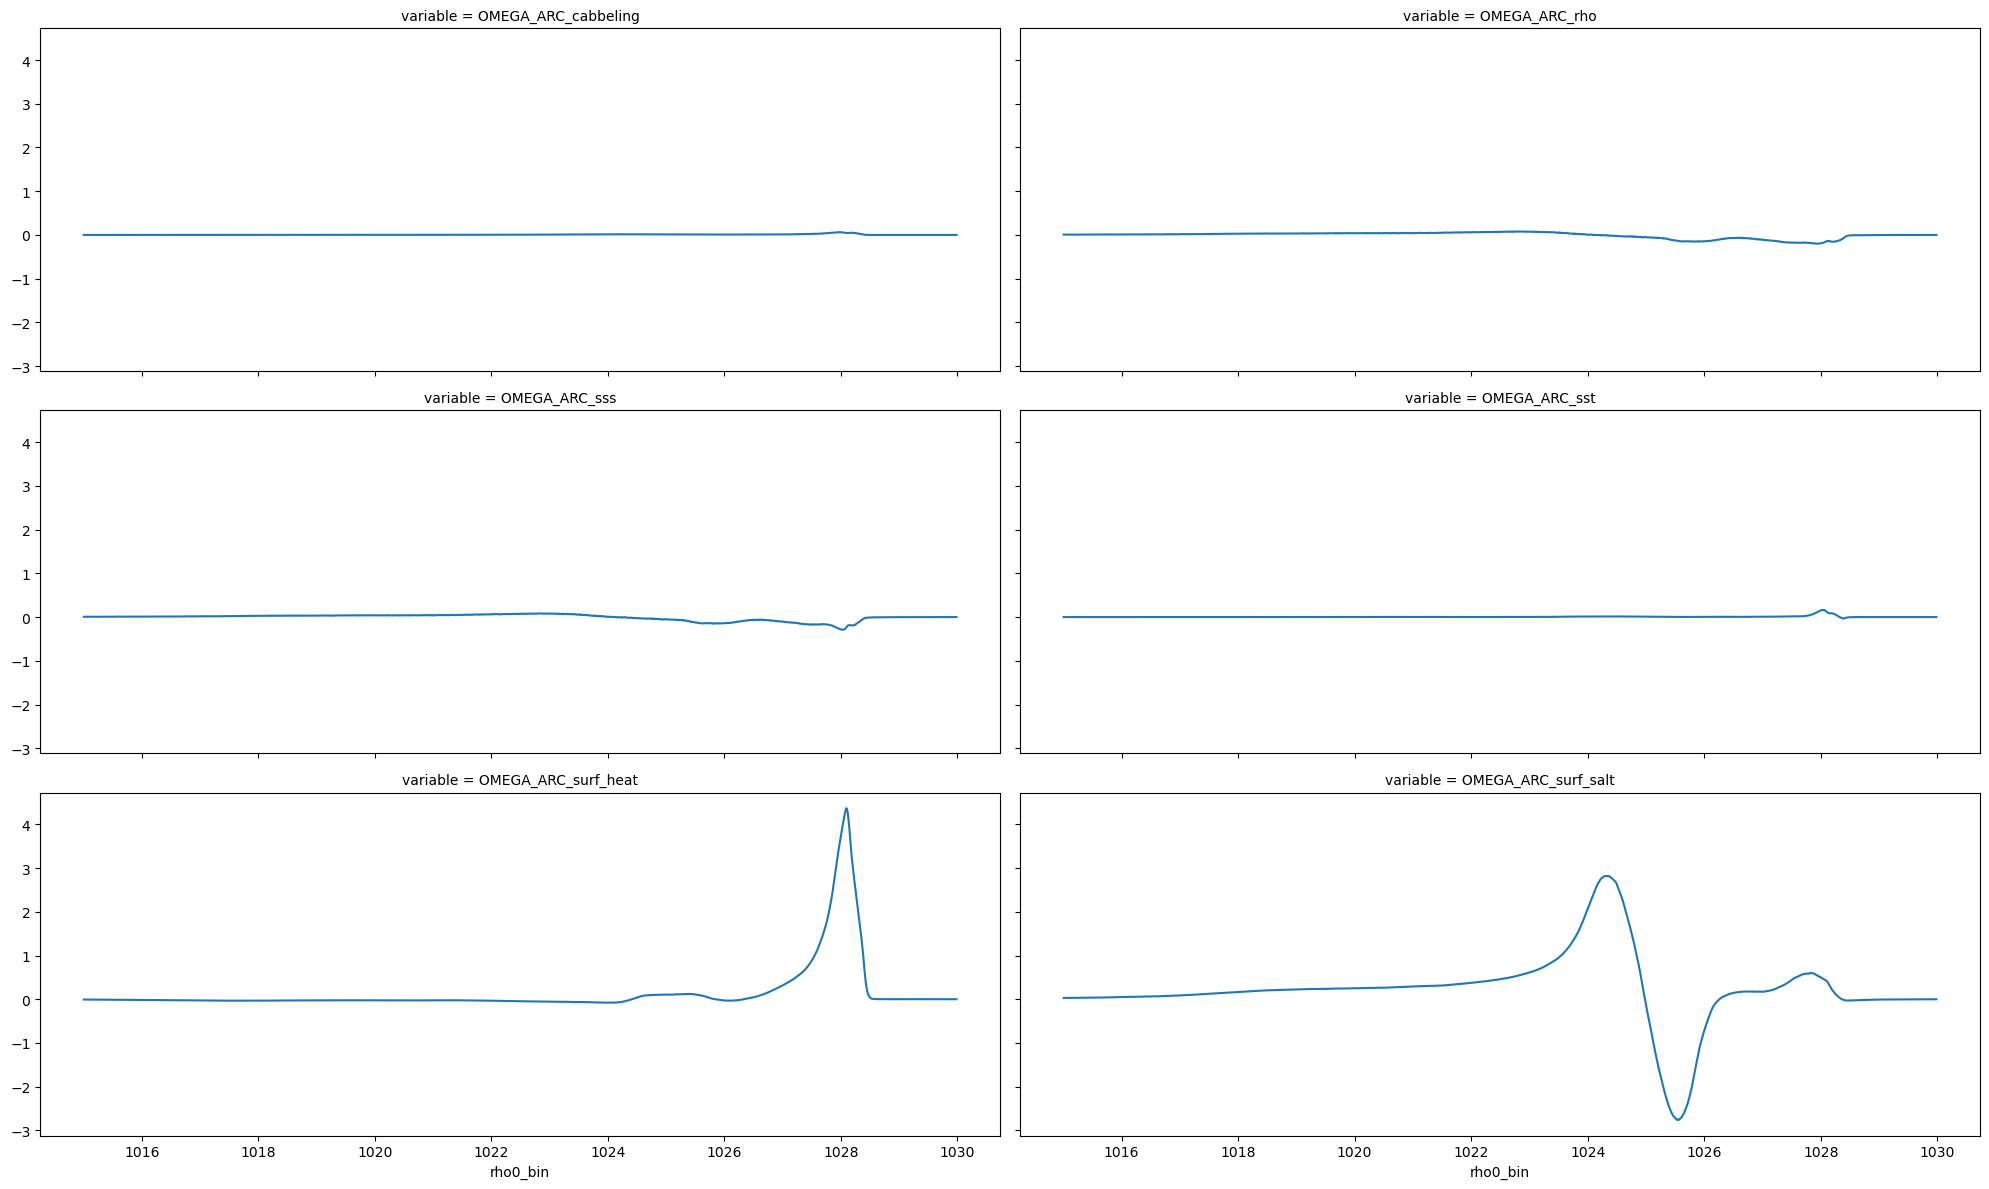

In [36]:
ann_mean1(arc)

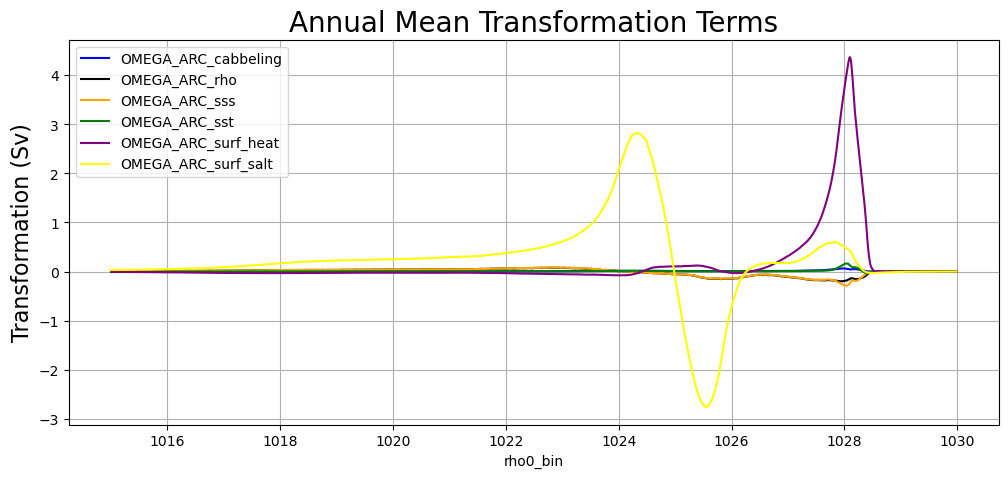

In [37]:
ann_mean2(arc)

## 1g) Annual-mean South fig

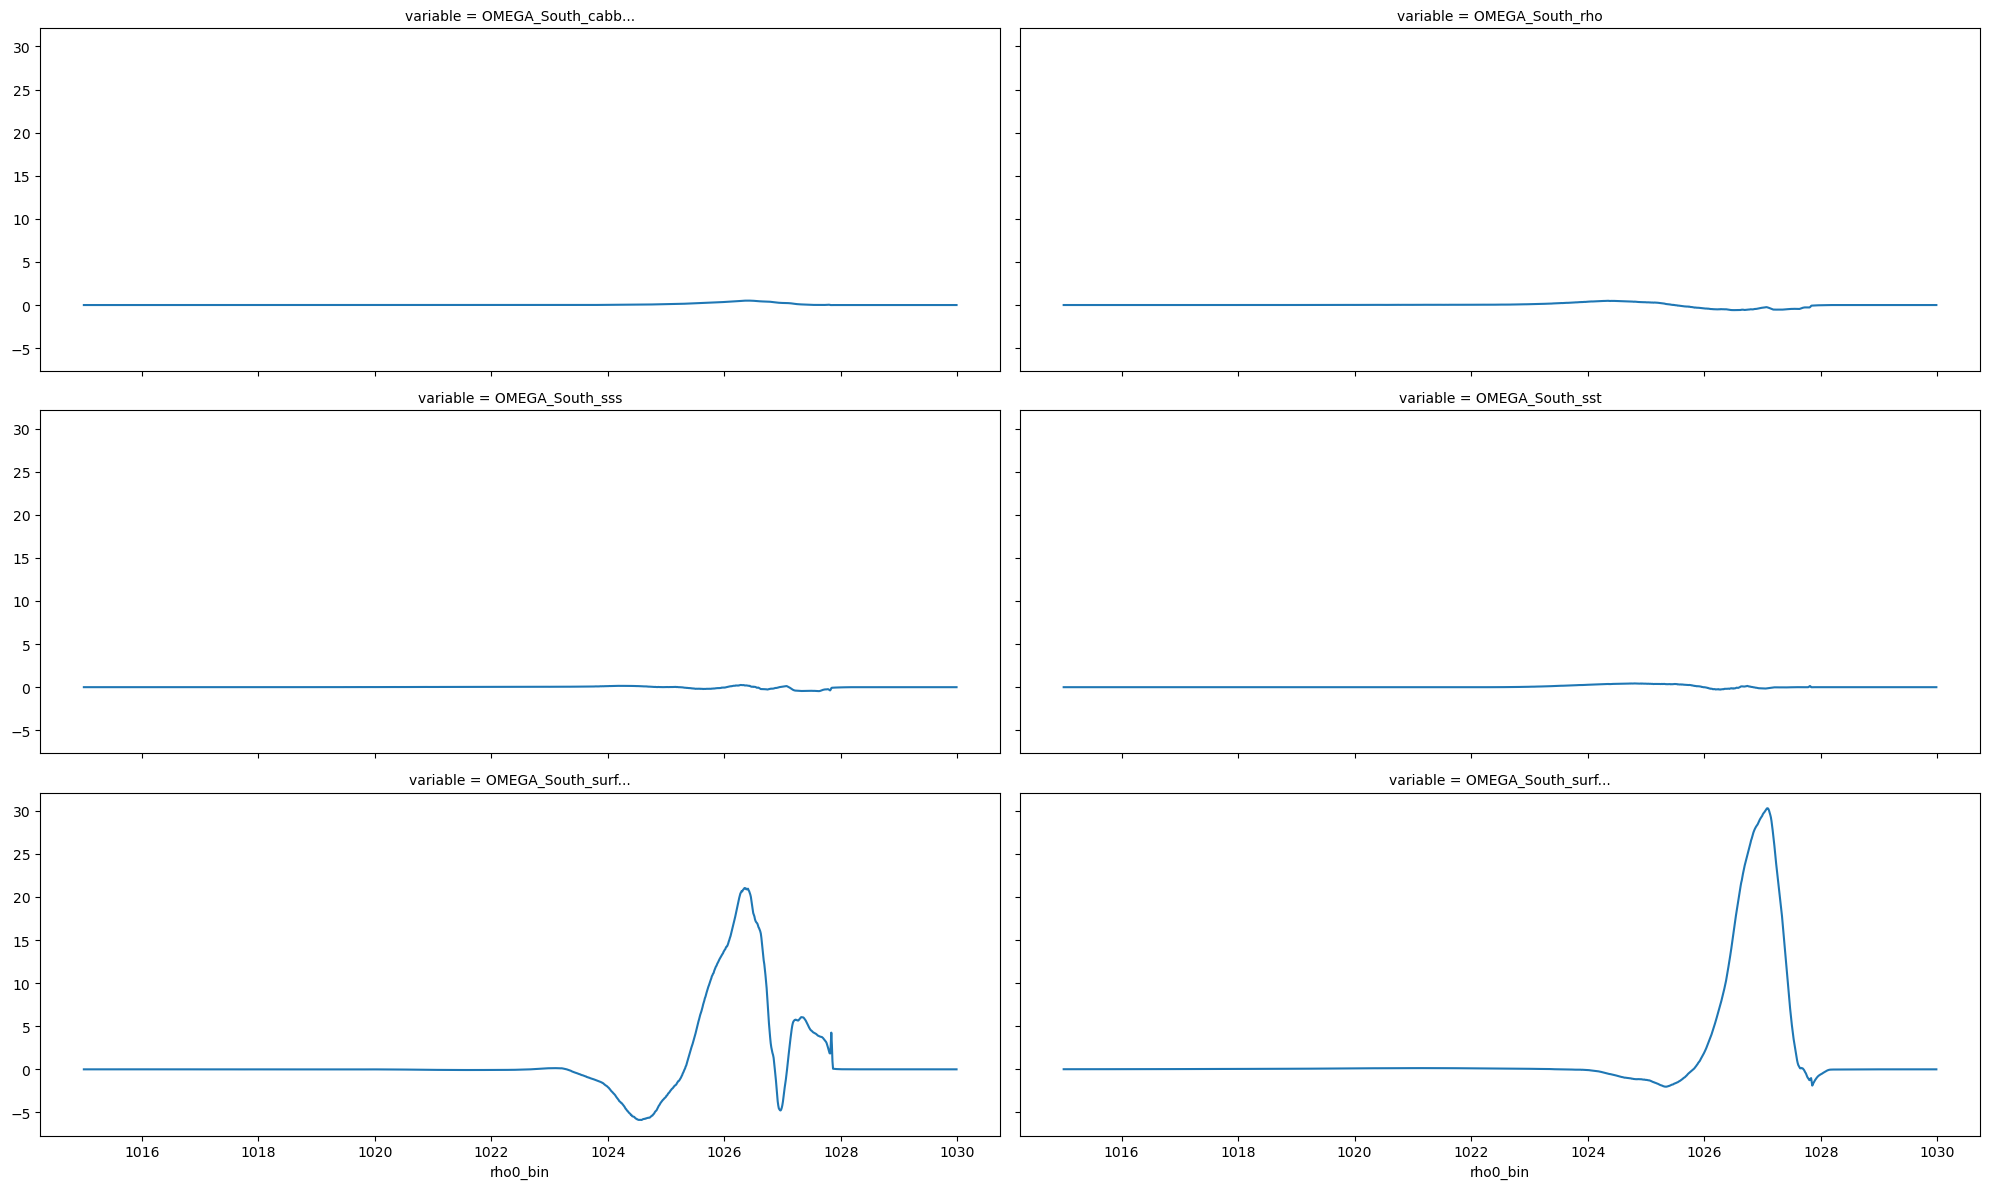

In [38]:
ann_mean1(south)

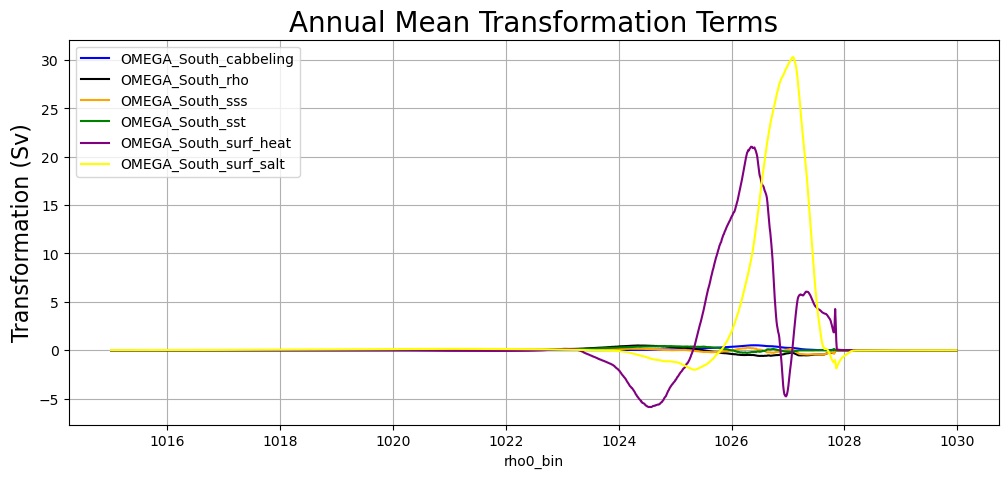

In [39]:
ann_mean2(south)

# 3) Global Monthly Climatology <a class='anchor' id='third-bullet'> </a>

In [40]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
def clim(da):
    clim = (da/1e6).groupby('time.month').mean(dim='time')
    return clim

In [42]:
clim_global = clim(global_hist)
clim_natl = clim(natl)
clim_satl = clim(satl)
clim_npac = clim(npac)
clim_spac = clim(spac)
clim_ind = clim(ind)
clim_arc = clim(arc)
clim_south = clim(south)

In [60]:
def plotting_global(ds, scale):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

    levels = np.arange(-200, 200) + 10

    ds.OMEGA_rho.plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[0,0])
    axes[0,0].set_title(r'Density ($\rho_0$)')
    axes[0,0].set_ylim(1029, 1018)
    axes[0,0].grid()

    ds.OMEGA_cabbeling.plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[0,1])
    axes[0,1].set_title('Cabbeling')
    axes[0,1].set_ylim(1029, 1018)
    axes[0,1].grid()

    ds.OMEGA_sst.plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[1,0])
    axes[1,0].set_title('SST')
    axes[1,0].set_ylim(1029, 1018)
    axes[1,0].grid()

    ds.OMEGA_sss.plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[1,1])
    axes[1,1].set_title('SSS')
    axes[1,1].set_ylim(1029, 1018)
    axes[1,1].grid()

    plt.suptitle(f'{scale} transformation due to ...', fontsize=20, y=1)
    plt.tight_layout();

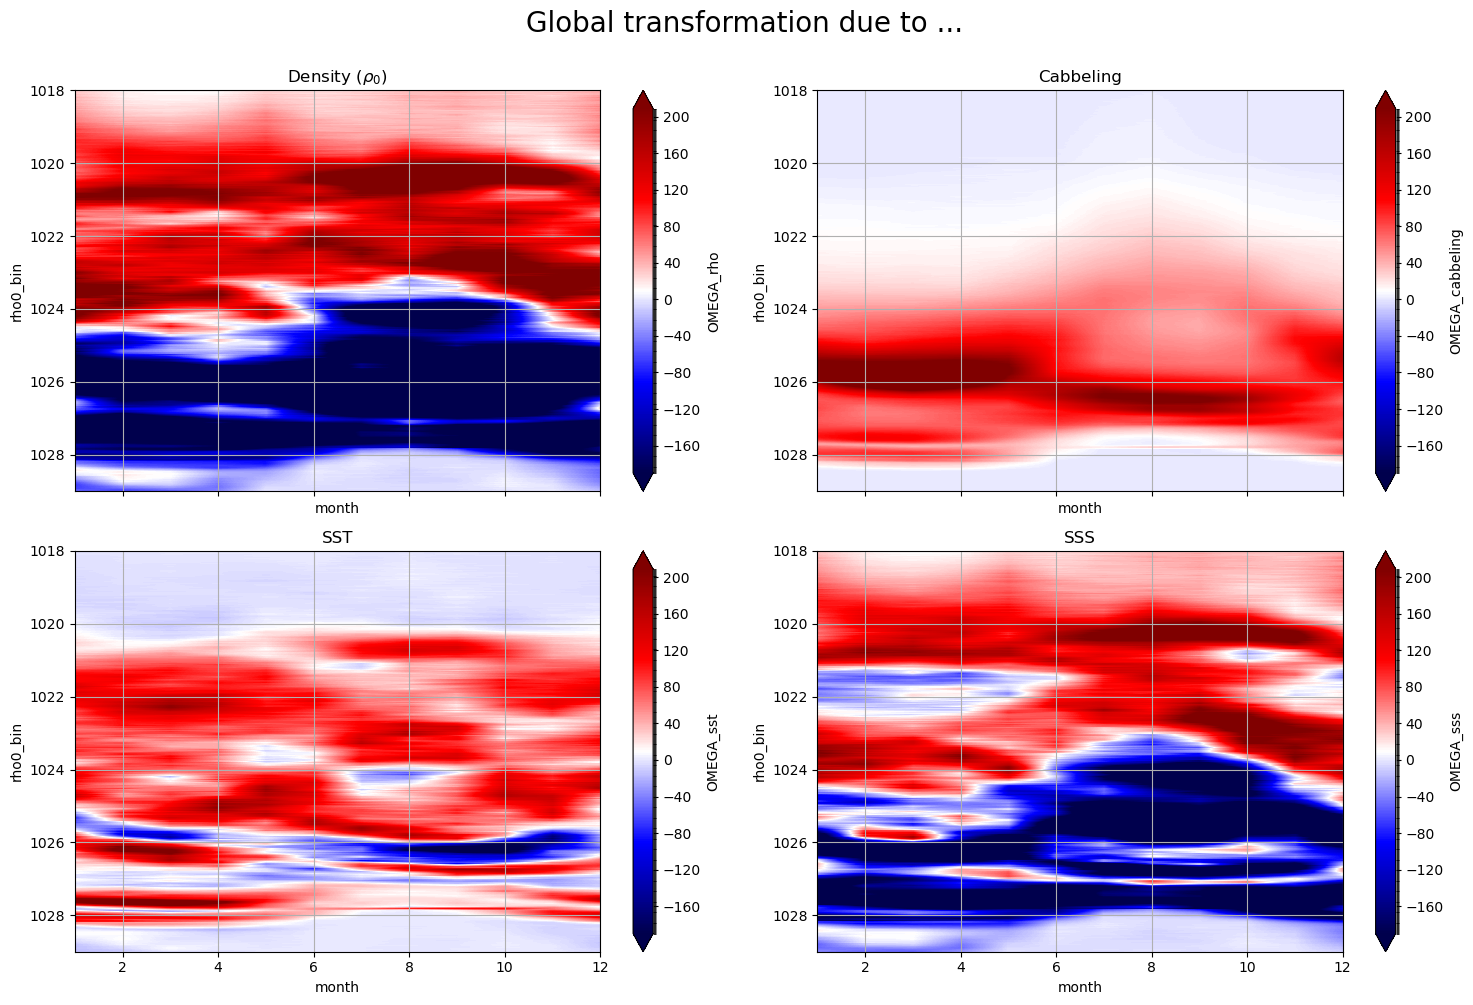

In [61]:
plotting_global(clim_global, 'Global')

## 3a) ATL monthly climatology

In [58]:
def plotting(ds, prefix, scale):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharex=True)

    levels = np.arange(-1.5, 1.5, 0.1)
    levels_surf = np.arange(-30, 30, 5)

    ds[f'OMEGA_{prefix}rho'].plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[0,0])
    axes[0,0].set_title(r'Density ($\rho_0$)')
    axes[0,0].set_ylim(1029, 1018)
    axes[0,0].grid()

    ds[f'OMEGA_{prefix}cabbeling'].plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[0,1])
    axes[0,1].set_title('Cabbeling')
    axes[0,1].set_ylim(1029, 1018)
    axes[0,1].grid()

    ds[f'OMEGA_{prefix}sst'].plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[1,0])
    axes[1,0].set_title('SST')
    axes[1,0].set_ylim(1029, 1018)
    axes[1,0].grid()

    ds[f'OMEGA_{prefix}sss'].plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[1,1])
    axes[1,1].set_title('SSS')
    axes[1,1].set_ylim(1029, 1018)
    axes[1,1].grid()

    ds[f'OMEGA_{prefix}surf_heat'].plot.contourf(x='month', cmap='seismic', levels=levels_surf, 
                                                 extend='both', ax=axes[2,0])
    axes[2,0].set_title('Surf_heat')
    axes[2,0].set_ylim(1029, 1018)
    axes[2,0].grid()

    ds[f'OMEGA_{prefix}surf_salt'].plot.contourf(x='month', cmap='seismic', levels=levels_surf, 
                                                 extend='both', ax=axes[2,1])
    axes[2,1].set_title('Surf_salt')
    axes[2,1].set_ylim(1029, 1018)
    axes[2,1].grid()

    plt.suptitle(f'{scale} transformation due to ...', fontsize=20, y=1)
    plt.tight_layout();

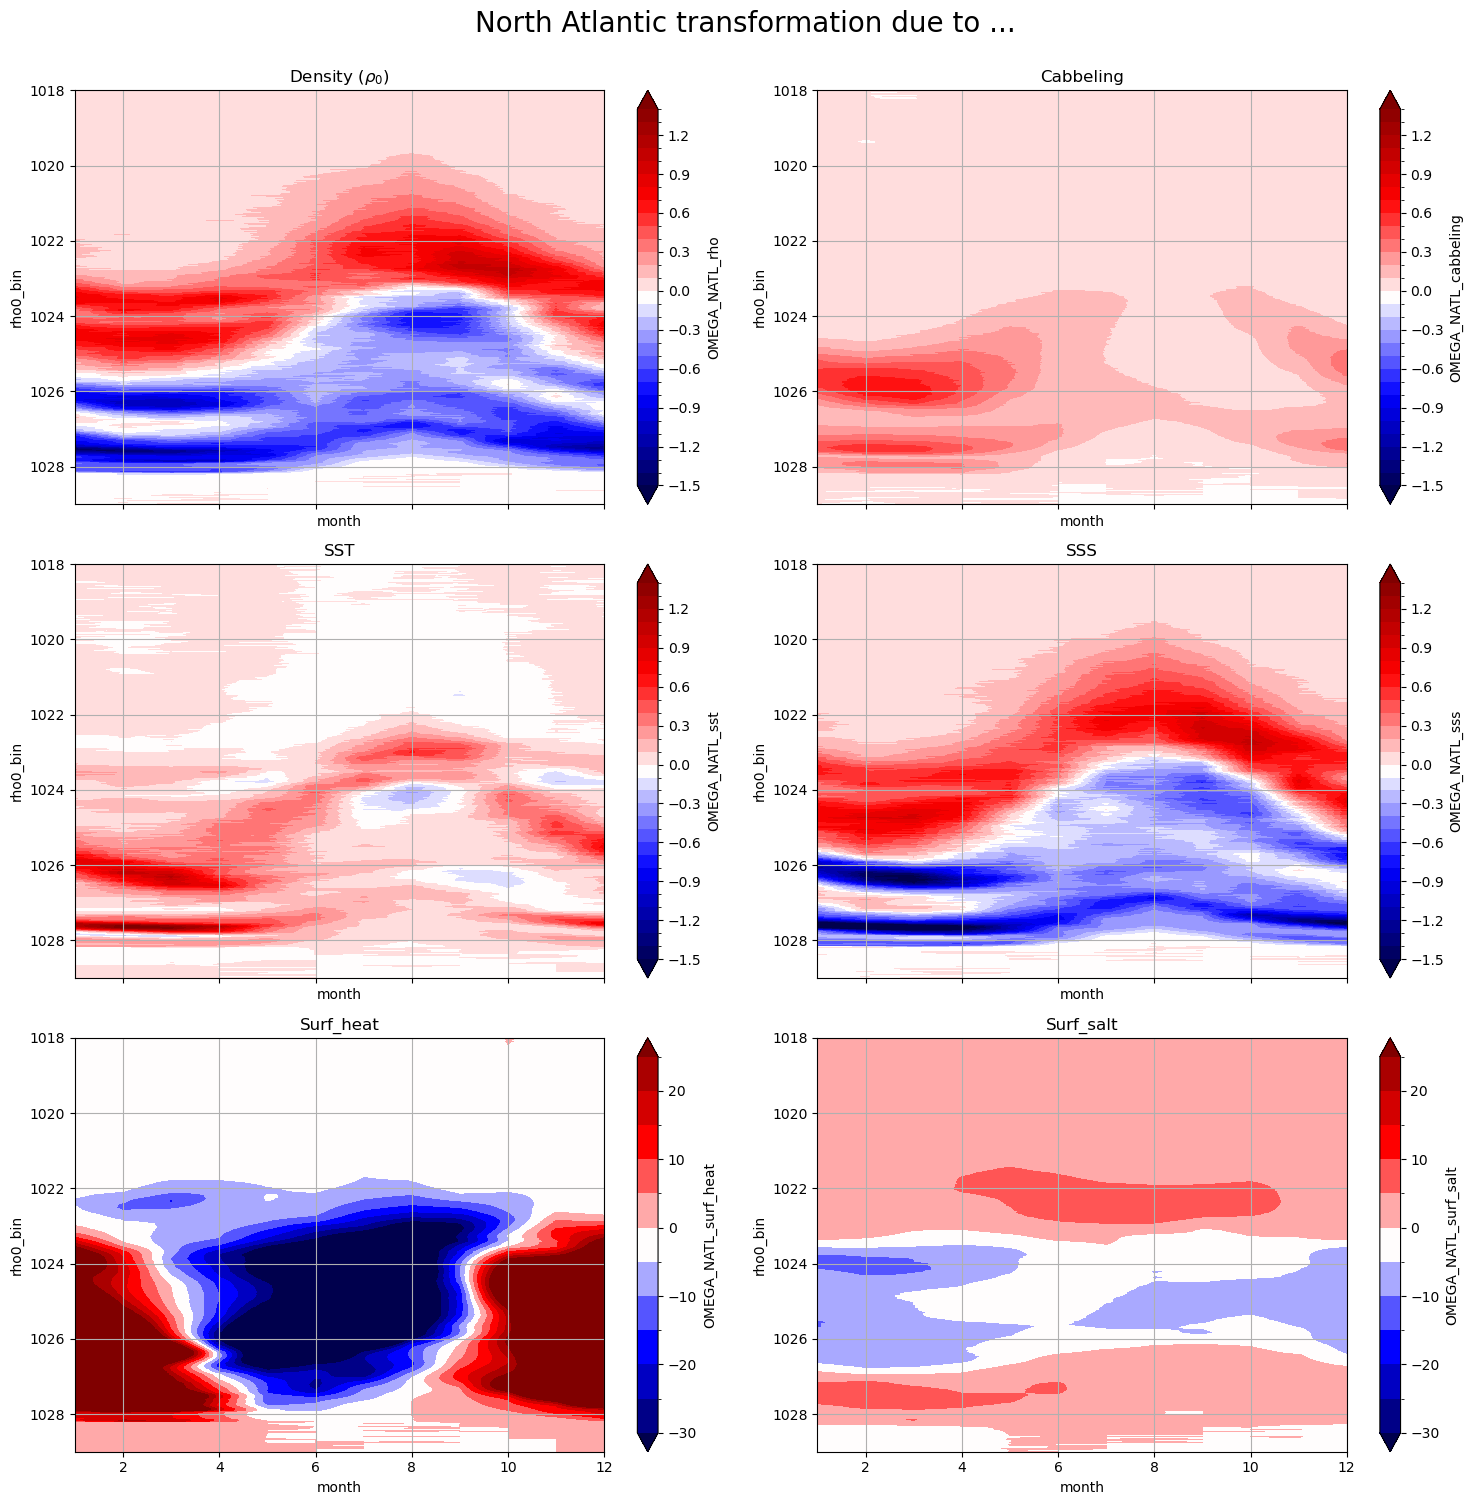

In [66]:
plotting(clim_natl, 'NATL_', 'North Atlantic')

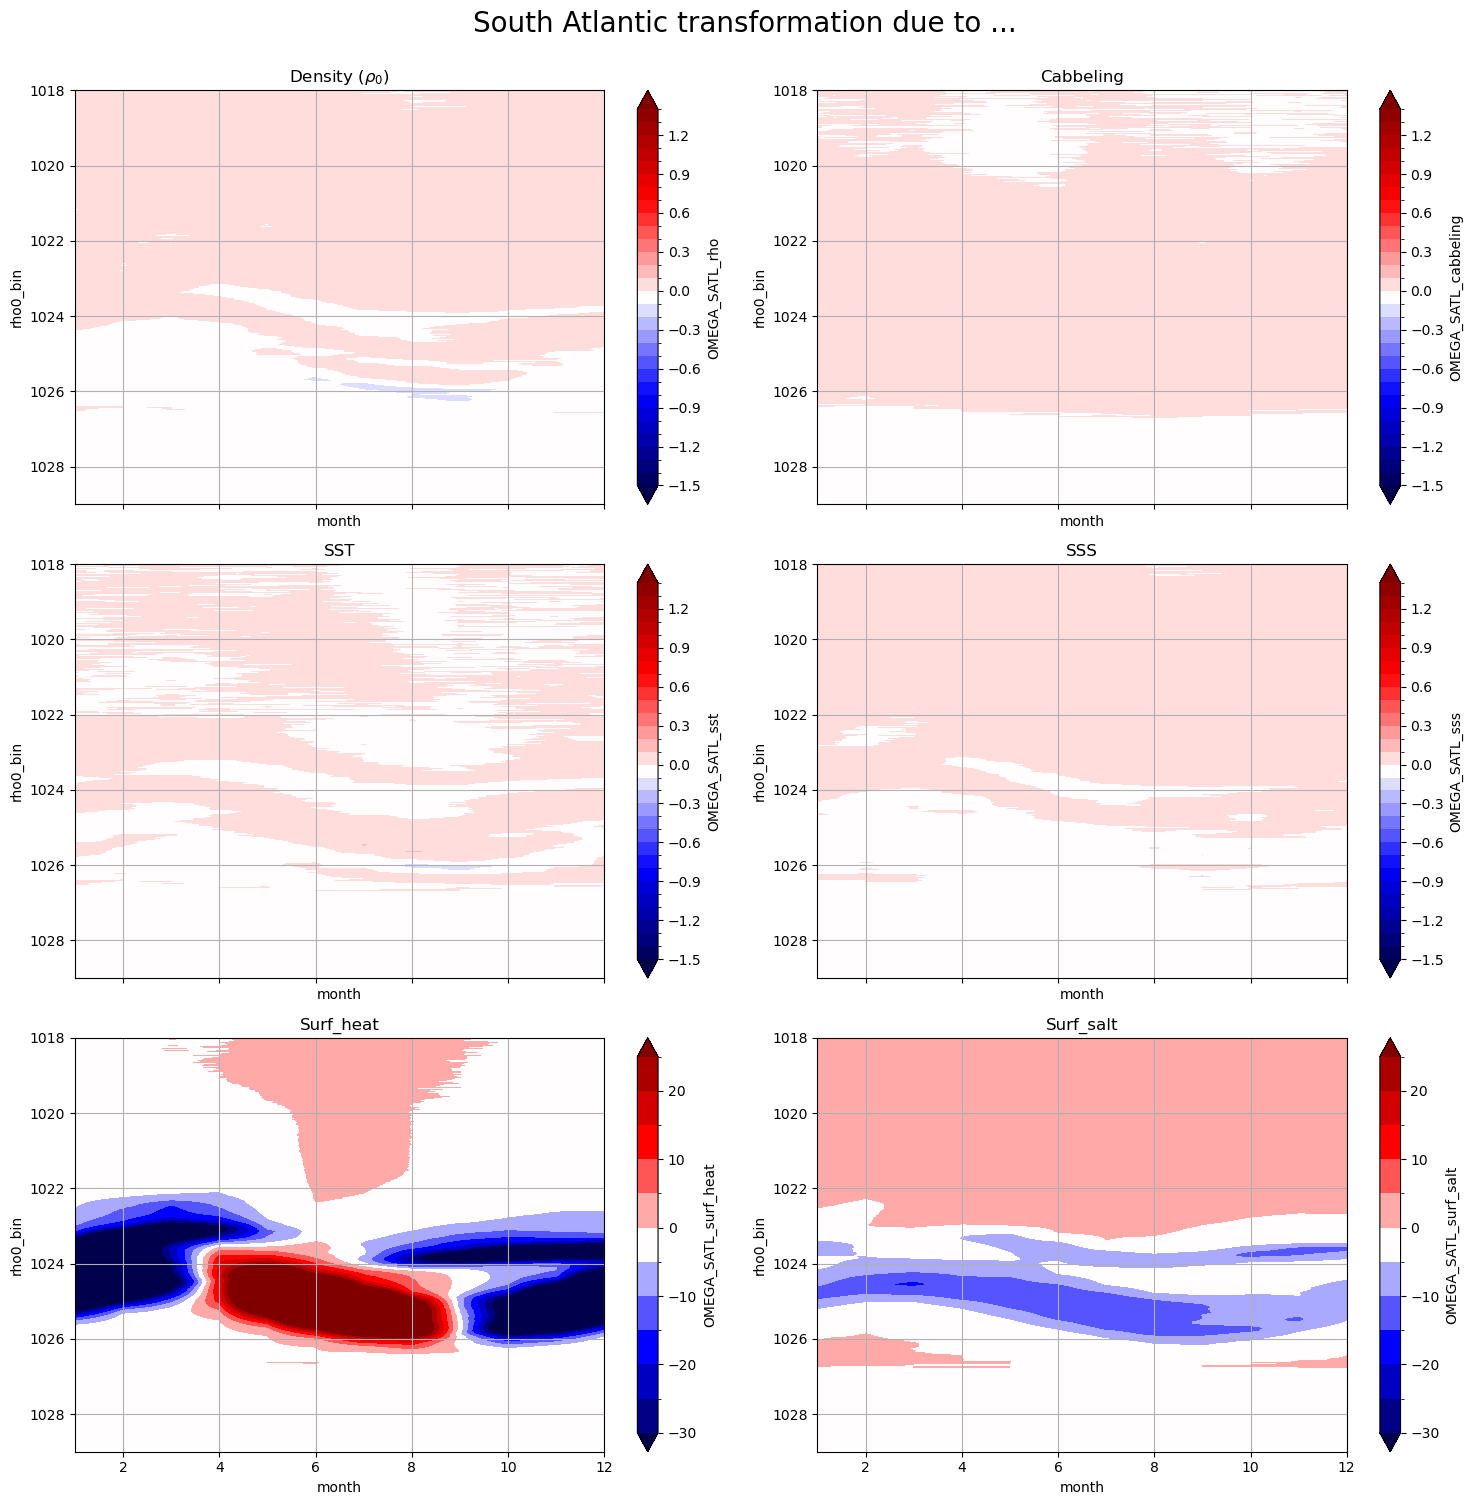

In [67]:
plotting(clim_satl, 'SATL_', 'South Atlantic')

## 3b) PAC monthly climatology

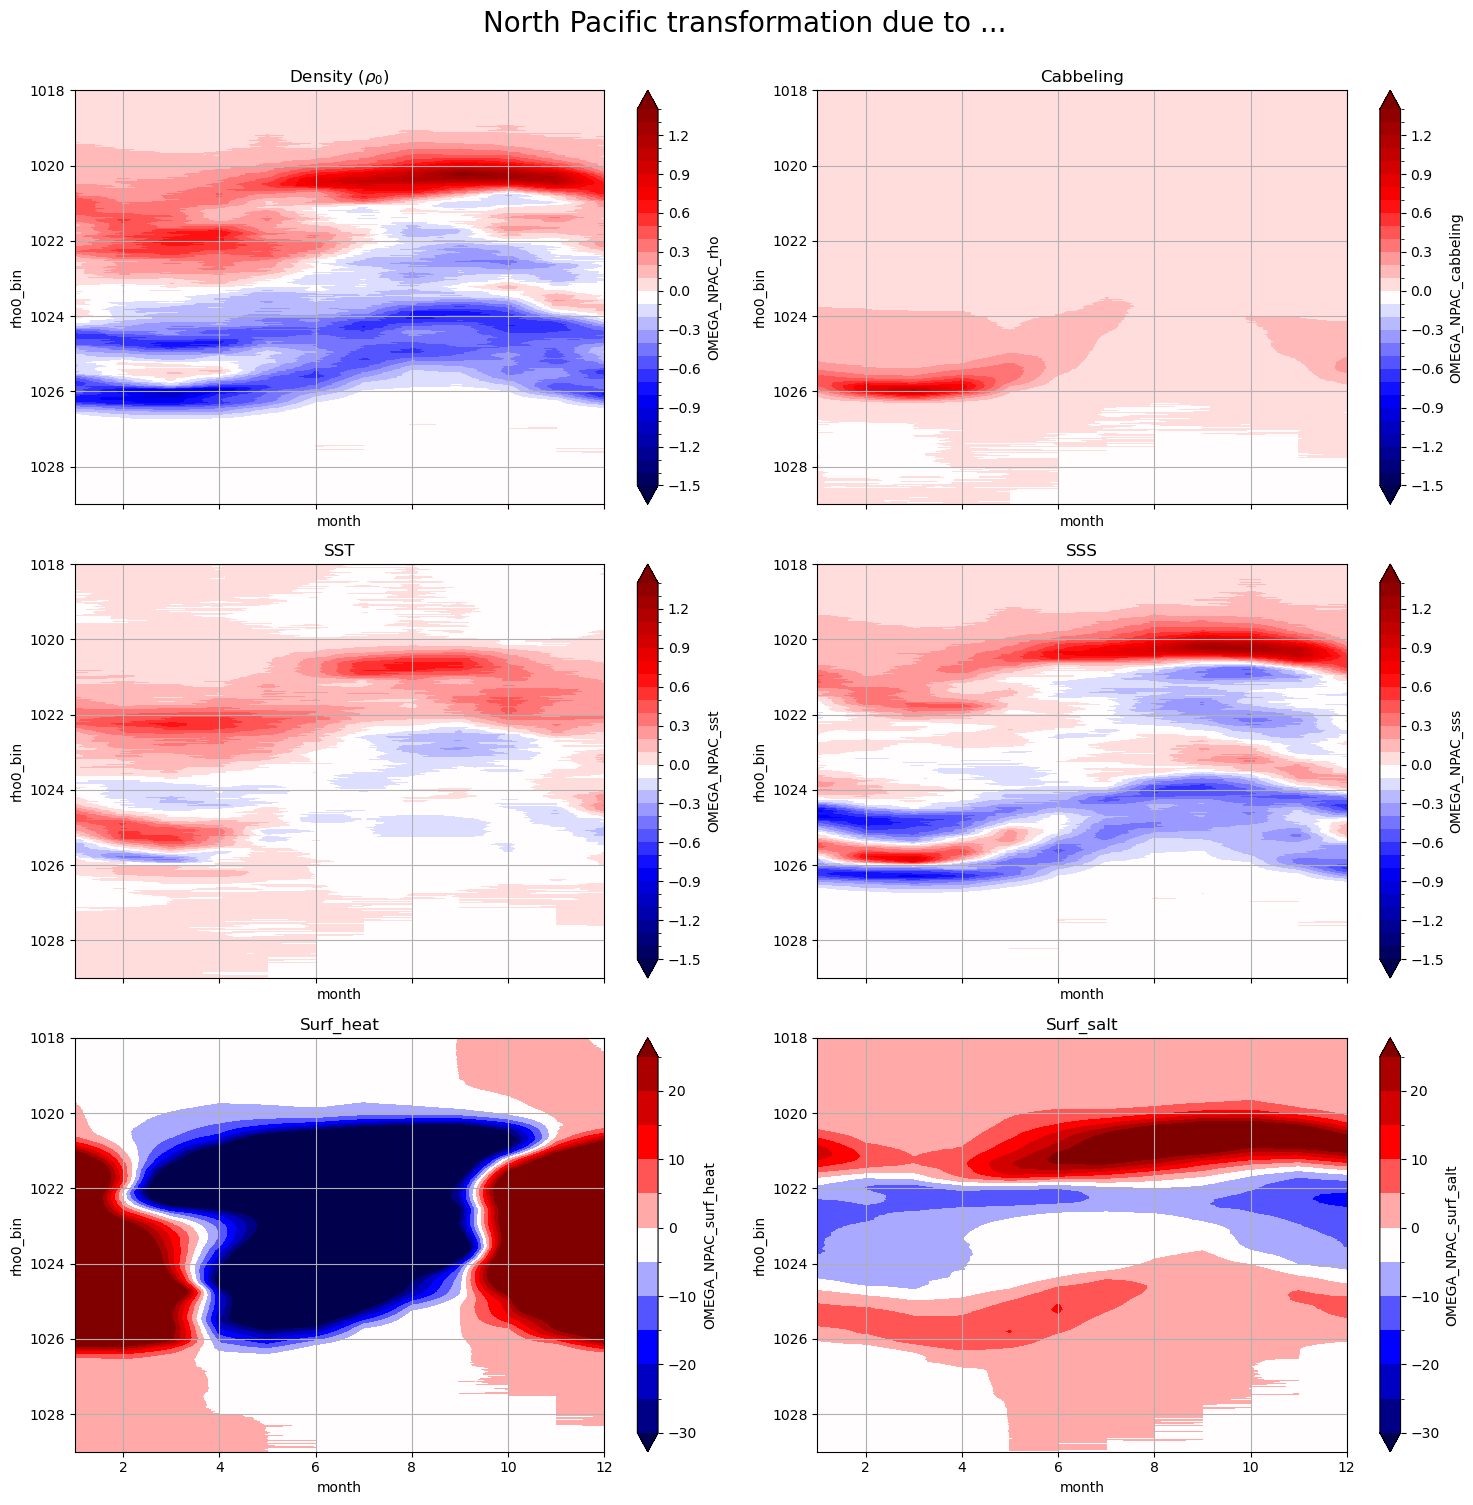

In [68]:
plotting(clim_npac, 'NPAC_', 'North Pacific')

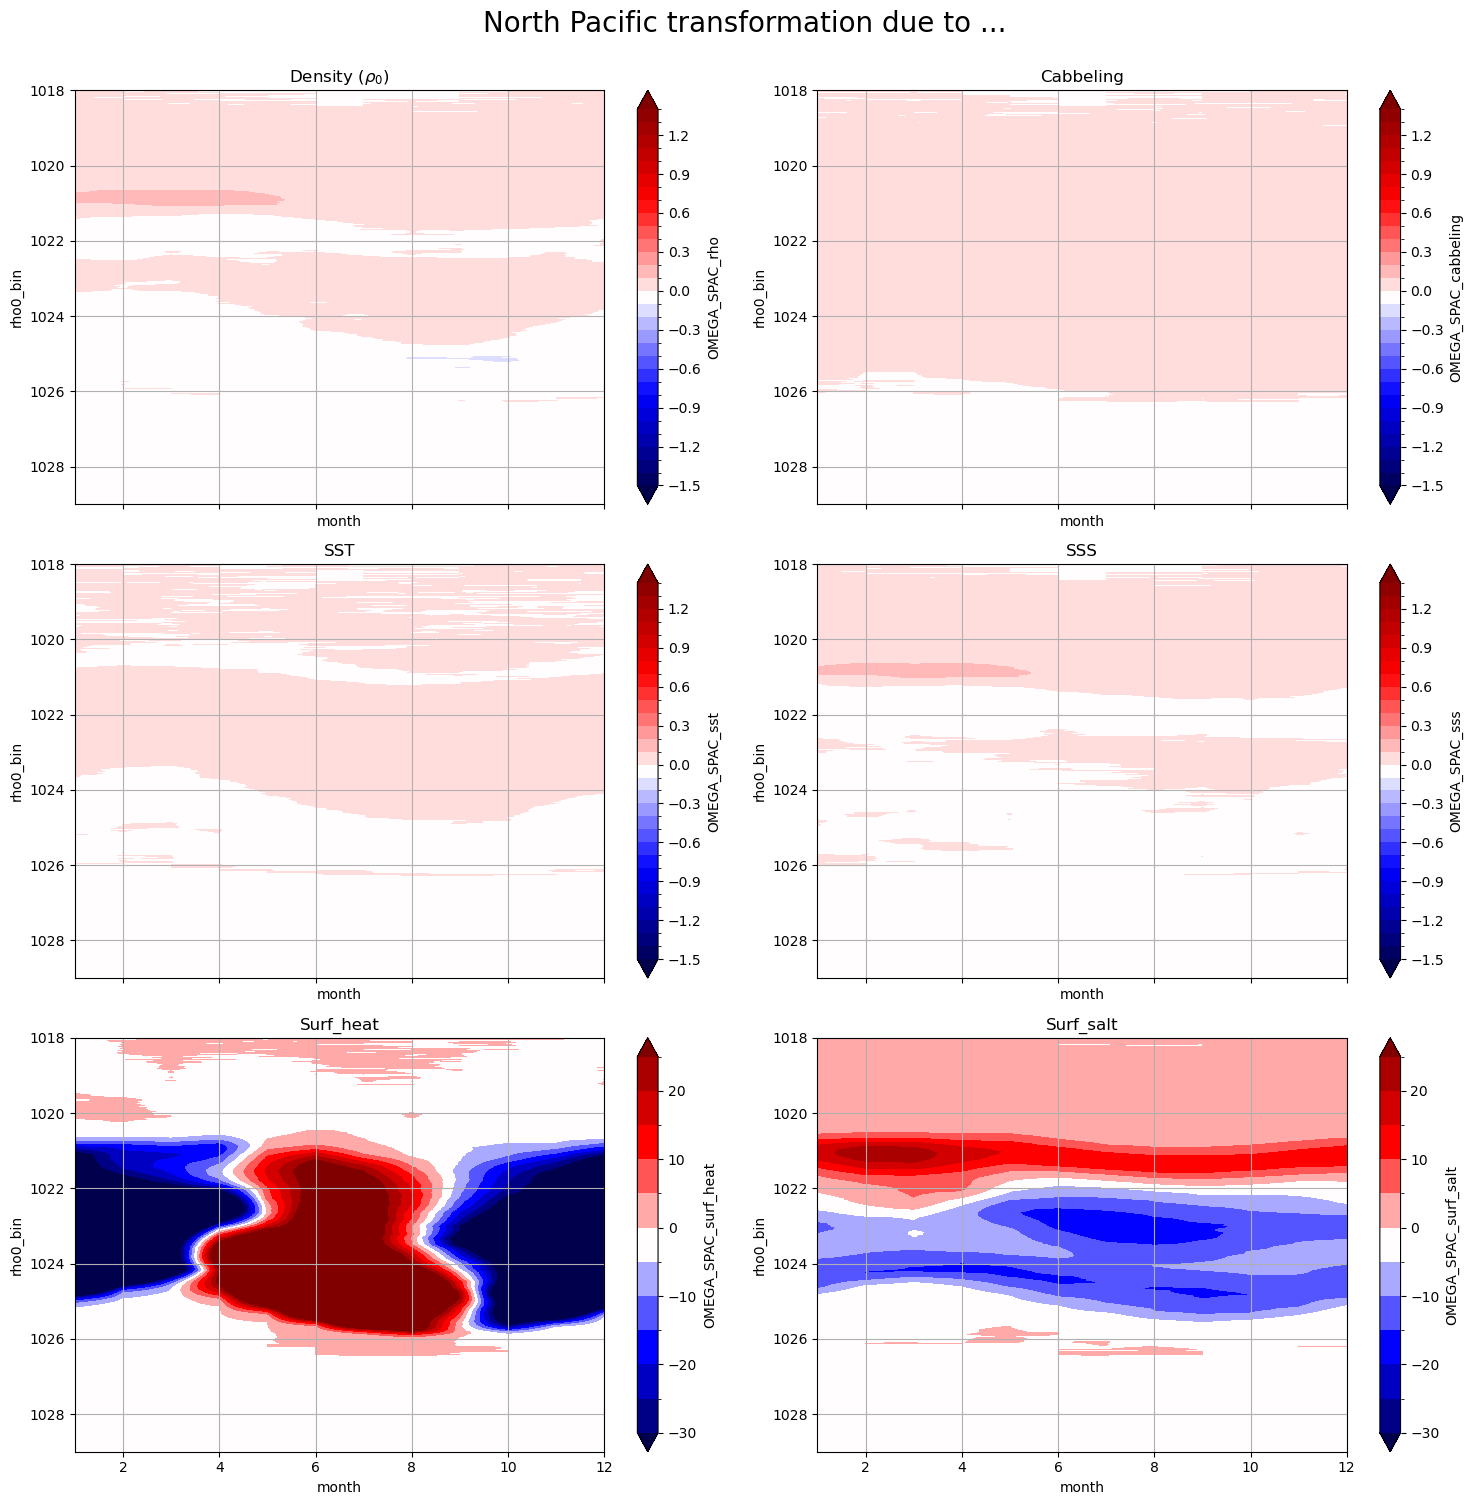

In [69]:
plotting(clim_spac, 'SPAC_', 'North Pacific')

## 3c) IND monthly climatology

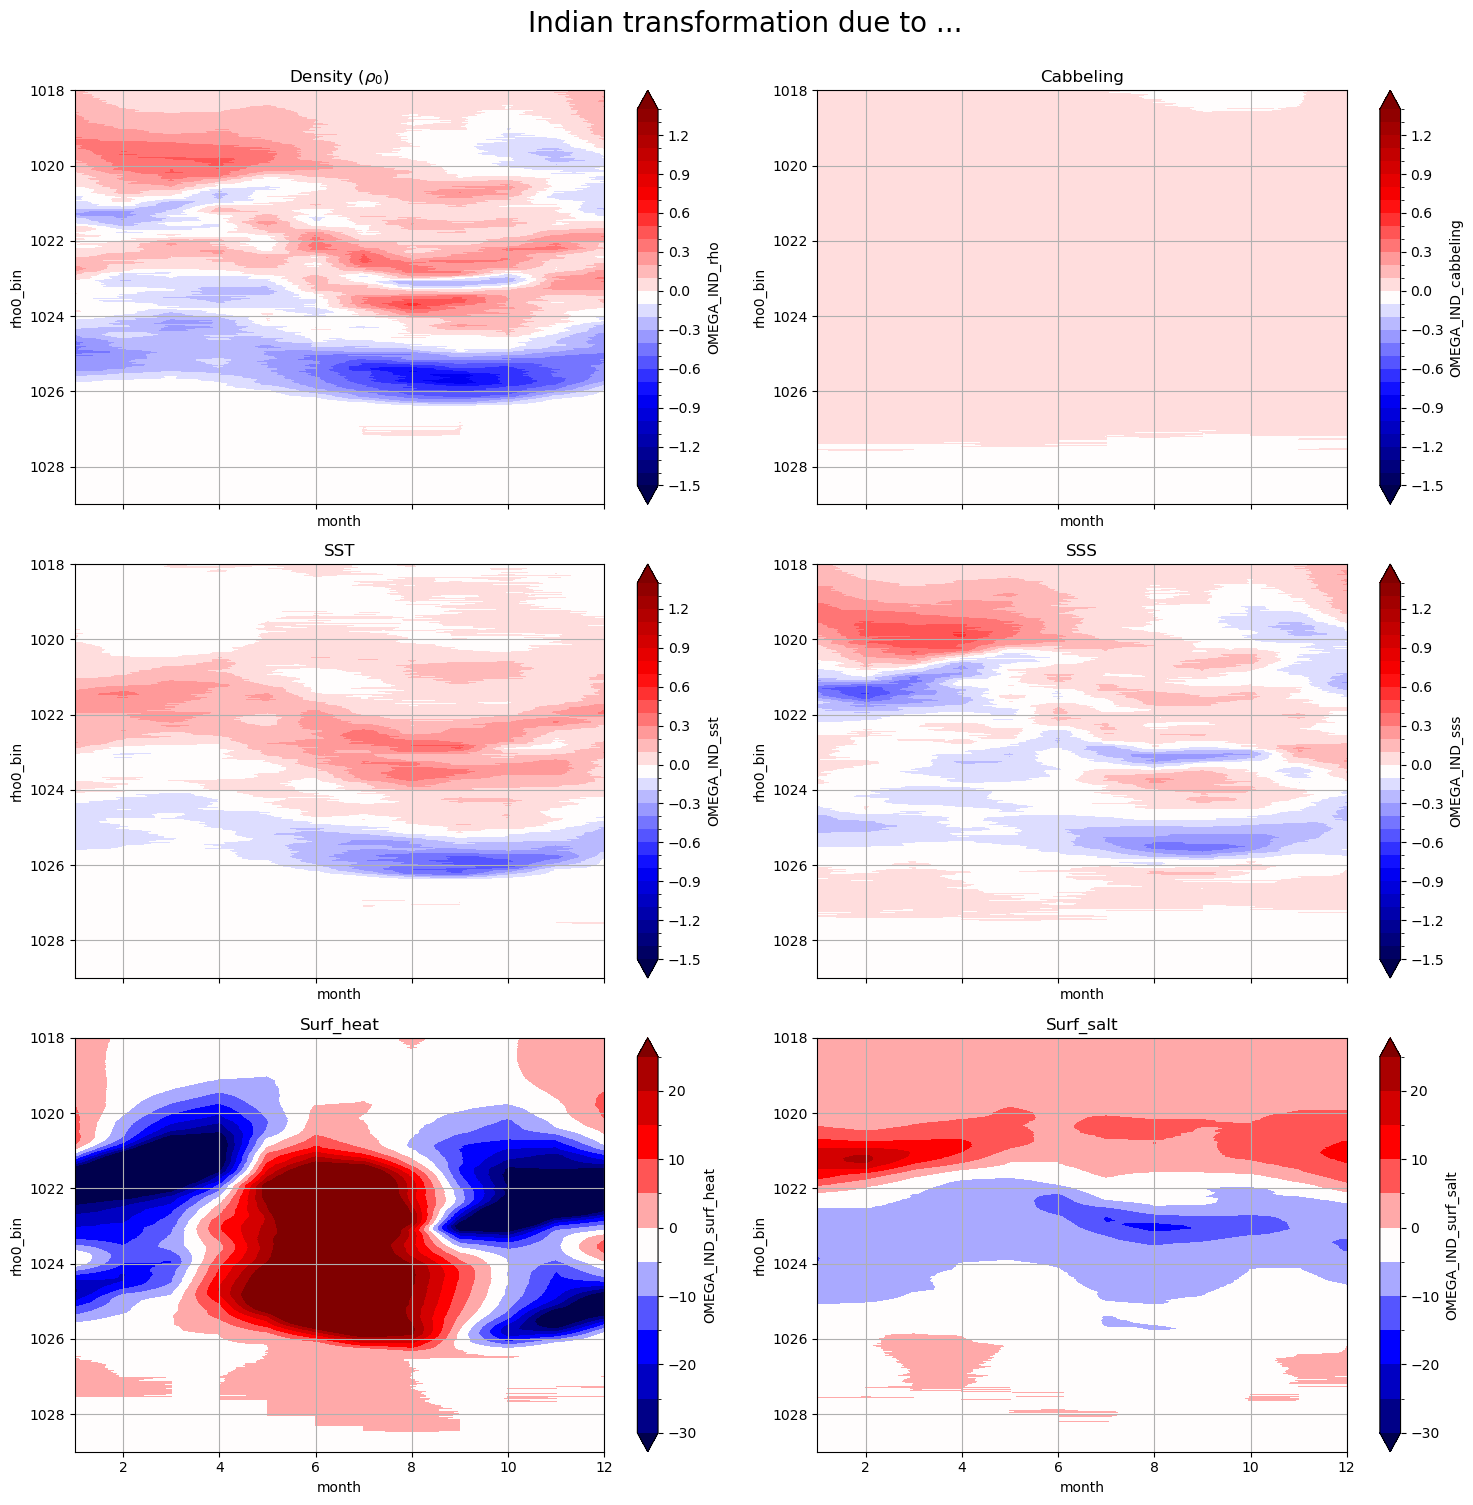

In [70]:
plotting(clim_ind, 'IND_', 'Indian')

## 3d) ARC monthly climatology

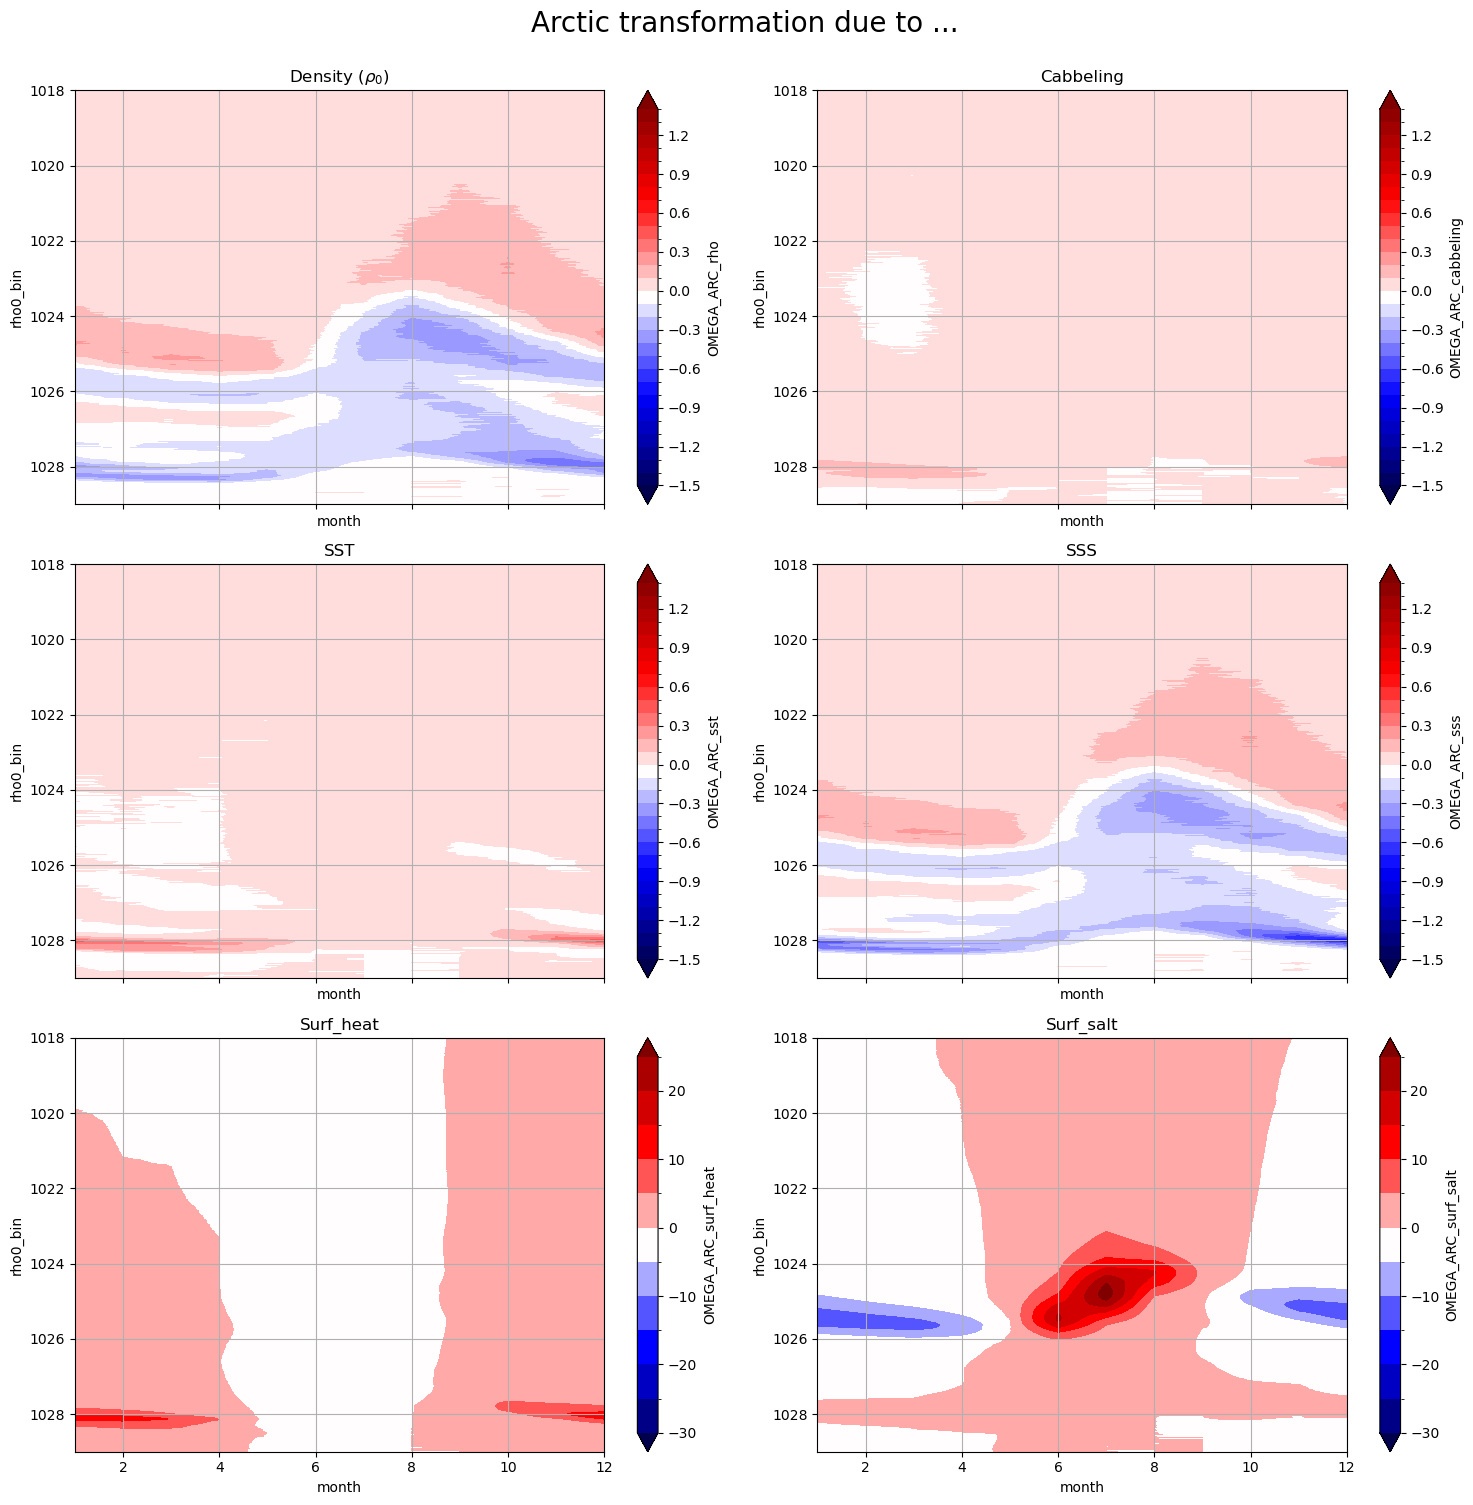

In [71]:
plotting(clim_arc, 'ARC_', 'Arctic')

## 3e) South monthly climatology

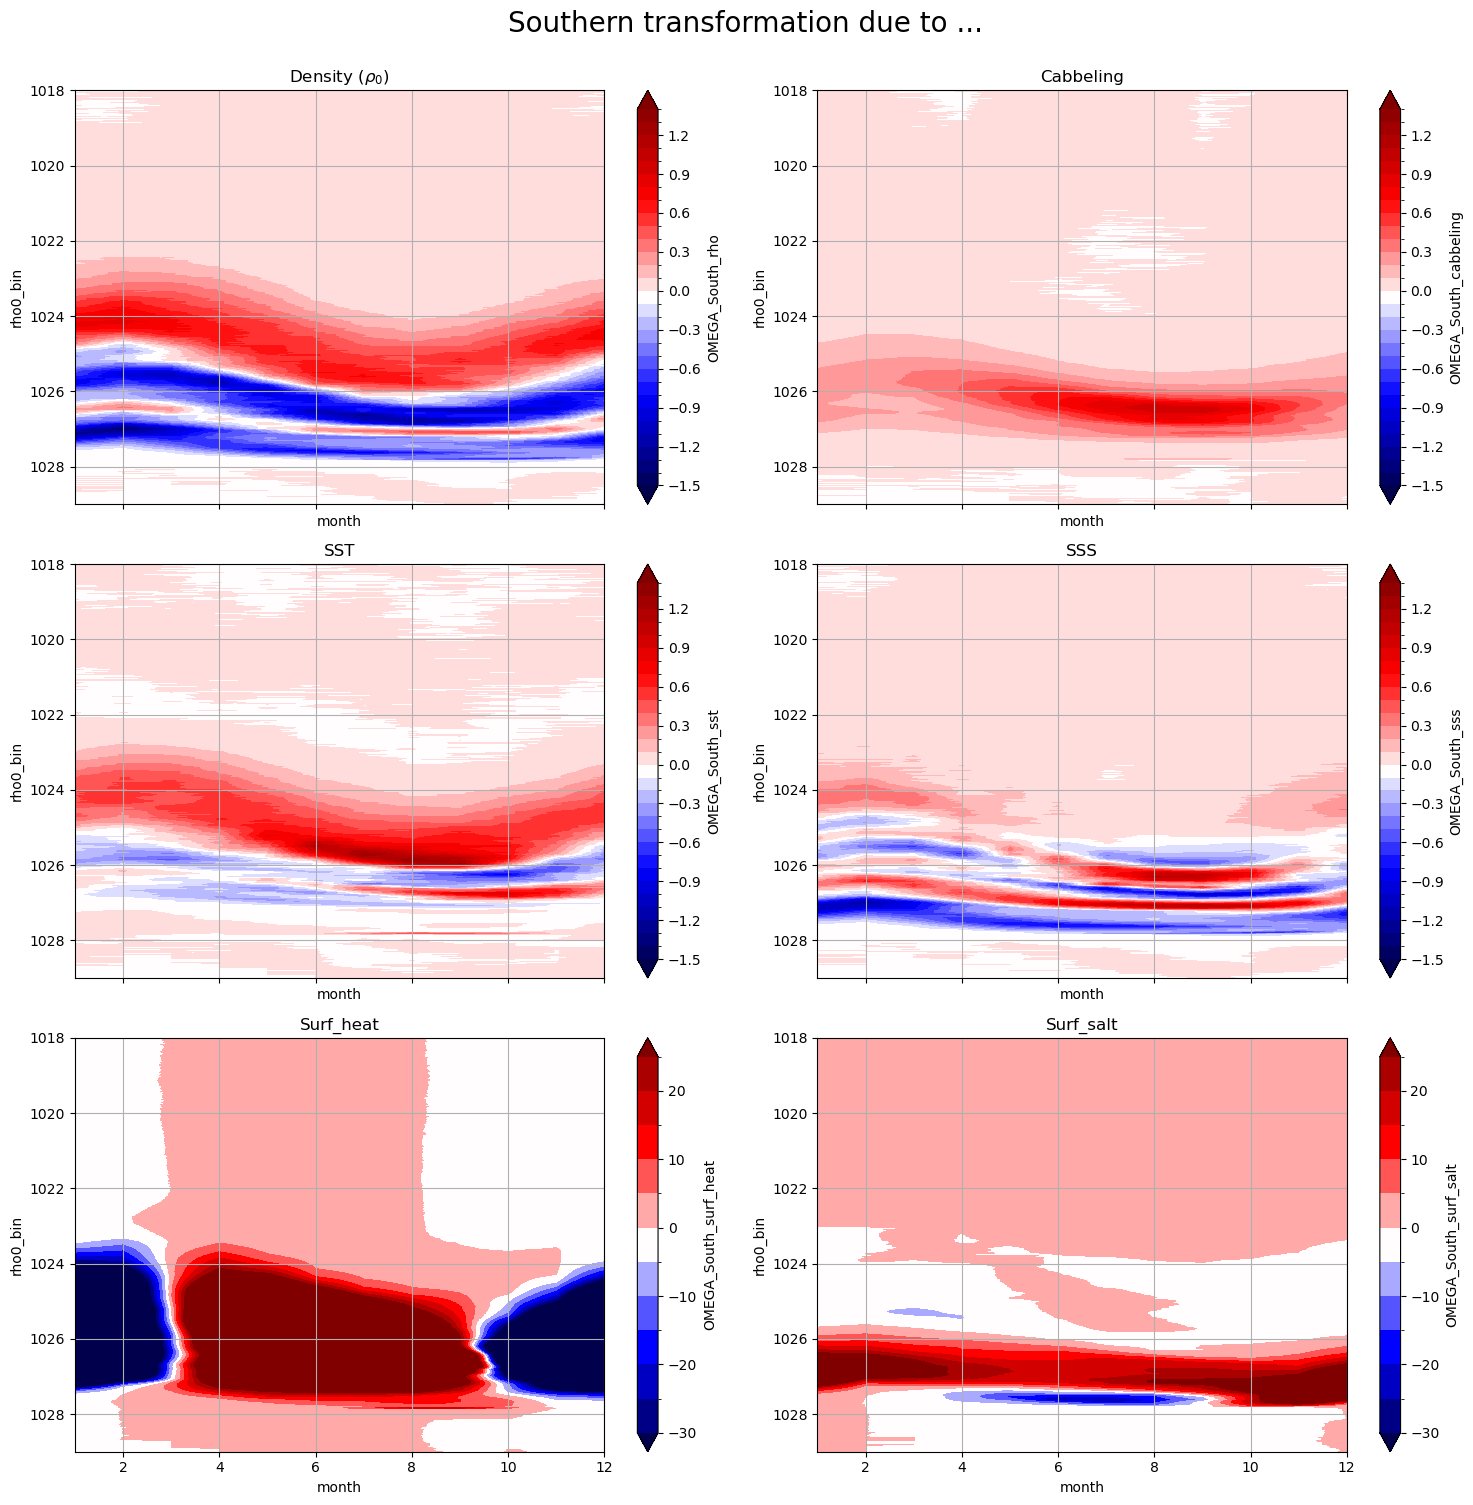

In [72]:
plotting(clim_south, 'South_', 'Southern')

In [73]:
cluster.close()
client.close()